##Clustering algorithms


#KMeans
In this section we will implemnt the KMeans unsupervised clustering algorithm, after that we will perform clustering analysis.

In [4]:
#DATAFRAME INITIALIZATION MODULE

#import clustering utilities
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score, rand_score

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder

#preprocessing module
df = pd.read_csv("ddos_dataset.csv",index_col=[0])
df["Flow ID"] = df[" Source IP"].astype(str)+"-"+df[" Destination IP"].astype(str)+"-"+df[" Source Port"].astype(str)+"-"+df[" Destination Port"].astype(str)+"-"+df[" Protocol"].astype(str)

df_processing = df.copy()

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to the 'Category' column
df_processing['label'] = label_encoder.fit_transform(df_processing['label'])

#proto one hot encoding
columns=["Protocol_0","Protocol_6","Protocol_17"]
encoder = OneHotEncoder()
one_hot_encoded = encoder.fit_transform(df_processing[[' Protocol']])
one_hot_encoded_array = one_hot_encoded.toarray()
one_hot_encoded_df = pd.DataFrame(one_hot_encoded_array, columns=columns,index=df.index)
df_processing = pd.concat([df_processing, one_hot_encoded_df], axis=1)

column_to_move = 'label'
new_position = df_processing.columns.size-1
column_pop = df_processing.pop(column_to_move)

# Insert the column at the new position
df_processing.insert(new_position, column_to_move, column_pop)

df_copy = df_processing.copy()

def isNotMostFrequentSrc(port):                       #FIX most frequent check done on both lists
     return not(port in most_frequent_source_ports)

def isNotMostFrequentDest(port):
     return not(port in most_frequent_destination_ports)

most_frequent_source_ports = df_copy[" Source Port"].value_counts()[:10].index
print("Most Frequent Source Ports:")
print(most_frequent_source_ports)

mask = [ isNotMostFrequentSrc(i) for i in df_copy[" Source Port"].values ]
df_copy.loc[mask," Source Port"] = -1

print(df_copy[" Source Port"].unique())

df_copy = pd.get_dummies(df_copy, columns=[' Source Port']) #get dummies is a one hot encoder
df_encoded = df_copy.copy()

most_frequent_destination_ports = df_encoded[" Destination Port"].value_counts()[:5].index
print("Most Frequent Destination Ports:")
print(most_frequent_destination_ports)

mask = [ isNotMostFrequentDest(i) for i in df_encoded[" Destination Port"].values ]
df_encoded.loc[mask," Destination Port"] = -1

print(df_encoded[" Destination Port"].unique())

df_encoded = pd.get_dummies(df_encoded, columns=[' Destination Port'])

column_to_move = 'label'
new_position = df_encoded.columns.size-1
column_pop = df_encoded.pop(column_to_move)

# Insert the column at the new position
df_encoded.insert(new_position, column_to_move, column_pop)

df_processed = df_encoded.drop([' Source IP', ' Destination IP', ' Timestamp','Flow ID','SimillarHTTP',' Protocol'], axis=1)

features_ddos = df_processed.columns[:-1] # 99 è label
GT = df_processed['label'].values         #labels are encoded


#Data Standardization
scaler = StandardScaler()
X = df_processed.copy().drop(columns='label')
X_s = X.copy()

for col in features_ddos:

    # fit the scaler on the data
    scaler.fit(X[col].values.reshape(-1, 1))

    # transform the data
    X_s[col] = scaler.transform(X[col].values.reshape(-1, 1))

correlation_matrix = X_s.corr().abs()

#correlation analysis
c = correlation_matrix
so = c.unstack().reset_index()

aa = pd.DataFrame(so)
#aa[0] is the internal value (correlation)
aa['sum'] = 0
# Get strongly correlatead features, removing pairs having correlation = 1 because of the diagonal, i.e., correlation between one feature and itself
aa = aa[(aa[0].isnull()==False) & (aa["level_0"] != aa["level_1"])]

for col in correlation_matrix.columns:
    mask = aa['level_0'] == col
    aa['sum'].loc[mask]=(aa[0].loc[mask]**2).sum()


aa = aa.sort_values([0,'sum'], ascending = False)

# Extract features having a correlation > 0.8
aa = aa[aa[0]>0.8]


# Get the unique set of features to be saved and the set to be deleted
to_be_saved = []
to_be_deleted = []

savedCandidates = list(aa["level_0"])
toBeDeletedCandidates = list(aa['level_1'])

# Notice that we discard one feature per time considering the case where a feature is strongly correlated with multiple features
subset_so = aa.copy()
for sav,tbd in zip(savedCandidates,toBeDeletedCandidates):
    if(sav not in to_be_deleted):
        if(sav in to_be_saved):
            to_be_deleted.append(tbd)
            subset_so = subset_so[(subset_so["level_0"] != tbd) & (subset_so["level_1"] != tbd)] # remove the rows that the removed feature is involved
        elif (tbd in to_be_saved): #if the candidate was saved before we cannot eliminate it in the future
            to_be_deleted.append(sav)
            subset_so = subset_so[(subset_so["level_0"] != sav) & (subset_so["level_1"] != sav)] # remove the rows that the removed feature is involved
        else:
            to_be_deleted.append(tbd)
            to_be_saved.append(sav) # add the feature to the removed candidates
            subset_so = subset_so[(subset_so["level_0"] != tbd) & (subset_so["level_1"] != tbd)] # remove the rows that the removed feature is involved

X_s_nored = X_s.copy()
x_uncorr = X_s.drop(columns = to_be_deleted)

## Ora rimuoviamo le righe null nella Correlation Matrix
rows_to_be_deleted = correlation_matrix[" Total Fwd Packets"].isnull() #select one rand. column
to_be_dropped = rows_to_be_deleted.loc[rows_to_be_deleted == True].index #correlation is null when there is a division by 0

X_s_red= x_uncorr.drop(columns=to_be_dropped) # <--
print(X_s_red.columns.size)

<ipython-input-4-f2c576248a56>:21: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("ddos_dataset.csv",index_col=[0])


Most Frequent Source Ports:
Int64Index([900, 634, 648, 672, 61850, 443, 80, 530, 512, 678], dtype='int64')
[  634    -1   443    80   530   512   678   900   648   672 61850]
Most Frequent Destination Ports:
Int64Index([53, 443, 80, 22, 0], dtype='int64')
[ -1   0  80 443  22  53]
43


In [21]:
# k-Means with n_clusters = 12 same as labels
X_s_red_np = X_s_red.to_numpy()


kmeans = KMeans(n_clusters=12)
cl_labels = kmeans.fit_predict(X_s_red_np) # Get clusters ID

# Unsupervised metric
silhouette  = silhouette_score(X_s_red_np, cl_labels)
# Supervised metrics
ri = rand_score(np.ravel(GT), cl_labels)
ari = adjusted_rand_score(np.ravel(GT), cl_labels)

print('k-Means with 12 clusters')
(unique, counts)=np.unique( cl_labels, return_counts=True)
print("Size of each cluster: ", counts)
print(f'k_means clustering error: {round(kmeans.inertia_, 2)}')
print(f'Silhouette: {round(silhouette, 2)}')
print(f'RI: {round(ri, 2)}')
print(f'ARI: {round(ari, 2)}')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


k-Means with 12 clusters
Size of each cluster:  [37961   748  8043   585  2138   562   117   608   919  1834    29 10695]
k_means clustering error: 1571758.81
Silhouette: 0.36
RI: 0.66
ARI: 0.18


In [22]:
#N_CLUSTERS TUNING

n_cluster_list=[]
shs_list = []
ri_list = []
ari_list = []
inertia_list=[]
X_s_red_np = X_s_red.to_numpy()
for n_clusters in range(10, 200, 10):
    kmeans = KMeans(n_clusters=n_clusters)
    cl_labels = kmeans.fit_predict(X_s_red_np)

    # Unsupervised metric
    silhouette  = silhouette_score(X_s_red_np, cl_labels)
    n_cluster_list.append(n_clusters)
    shs_list.append(silhouette)
    ri_list.append(rand_score(np.ravel(GT), cl_labels))
    ari_list.append(adjusted_rand_score(np.ravel(GT), cl_labels))
    inertia_list.append(kmeans.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

best k:  170  with corresponding silhouette:  0.7811016536039946


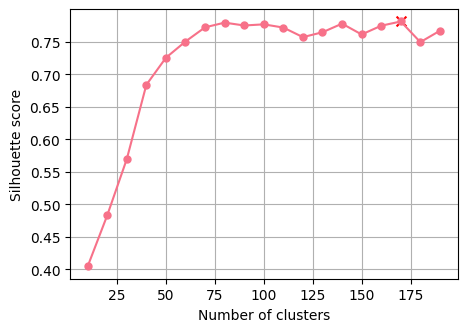

In [23]:
# Get n_clusters leading to the best metrics
# N_Clusters = 50 for elbow method
best_sh= np.max(shs_list)
best_n=n_cluster_list[np.argmax(shs_list)]
print("best k: ",best_n, " with corresponding silhouette: ", best_sh)

# Plot silhouette
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list,shs_list, marker='o', markersize=5)
plt.scatter(best_n, best_sh, color='r', marker='x', s=50)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()


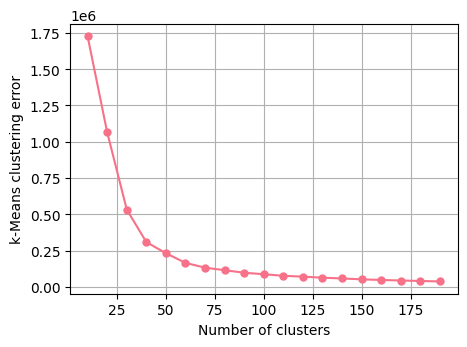

In [24]:
# Plot k-Means clustering error(inertia)
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list,inertia_list, marker='o', markersize=5)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('k-Means clustering error')
plt.show()

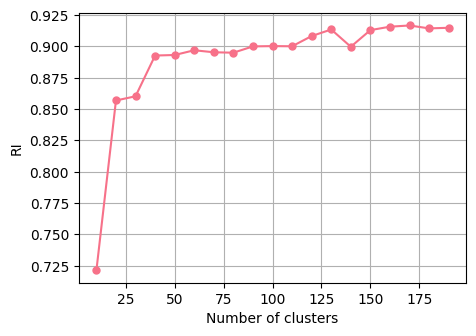

In [25]:
# Plot RI
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list,ri_list, marker='o', markersize=5)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('RI')
plt.show()

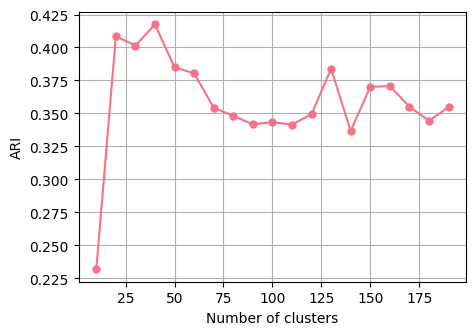

In [26]:
# Plot ARI
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list,ari_list, marker='o', markersize=5)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('ARI')
plt.show()

In [27]:
#IMPORTANT NOTICE: Due to the randomic nature of the centroid selection, different results may occur.

#finding the best centroids
#every cycle the kmeans runs 10 times selecting the best centroids based on the inertia, so 100 runs of kmeans at the end
sil_list = []
ri_list = []
cent_list = []

X_s_red_np = X_s_red.to_numpy()
for i in range(10):
  print(f'{i}----------------------------------')
  kmeans = KMeans(n_clusters=50, init='random', n_init='auto', random_state=None, verbose=0)
  cl_labels = kmeans.fit_predict(X_s_red_np) # Get clusters ID

  # Unsupervised metric
  silhouette  = silhouette_score(X_s_red_np, cl_labels)
  # Supervised metrics
  ri = rand_score(np.ravel(GT), cl_labels)
  ari = adjusted_rand_score(np.ravel(GT), cl_labels)

  (unique, counts)=np.unique( cl_labels, return_counts=True)
  print("Size of each cluster: ", counts)
  print(f'k_means clustering error: {round(kmeans.inertia_, 2)}') #inertia is the sum of squared distances btween samples and their cluster
  print(f'Silhouette: {round(silhouette, 2)}')
  print(f'RI: {round(ri, 2)}')
  print(f'ARI: {round(ari, 2)}')
  sil_list.append(silhouette)
  ri_list.append(ri)
  cent_list.append(kmeans.cluster_centers_)



0----------------------------------
Size of each cluster:  [5449 1649    9   55  811 3340 5423 3990  537   18  373  156    1  746
    1    3    1    1  473   19 1906  428  191    2  117  117 4142 2890
 4162 3496  662 1663 1762    3 1300 9714 1025 1928 1454  474    5    6
 2012    1    1    8  489  166 1049   11]
k_means clustering error: 615375.5
Silhouette: 0.66
RI: 0.91
ARI: 0.35
1----------------------------------
Size of each cluster:  [3369 3939  117 1617 1030  565   27   19  234  233 1865 8591 2009  373
    5    1 5242    2  971  671 5962    1   10  560  444 3397    1 4219
 1918  928 1152  452 4118  408 1713    1    6  467   11 1947  319  156
 1025 2125    3 1499  156   39  305   17]
k_means clustering error: 547846.77
Silhouette: 0.69
RI: 0.92
ARI: 0.43
2----------------------------------
Size of each cluster:  [ 452 5449 3587  531 3397    2    3  159 2131 3195    1  265  210    1
 1027   55 1708 4118  606 3494    1 6058  745   26 3013  883  491  560
 1739    1 2908  251    6  7

In [7]:
#43x50 MATRIX OF THE BEST CENTROIDS FOUND

best_centroids = [[-0.03637202, -0.05174846, -0.27352545, -0.17227677, -0.14626084, -0.232138, -0.01545204, -0.11238352, -0.09695277, -0.11360753, -0.09603135, 0.0039422, 1.06618363, -0.0449771, -0.07536963, -0.11528979, -0.13070681, -0.02432881, -0.22410524, -0.26552317, 0.0977318, -0.26631448, -0.10288135, 0.20202313, -0.0440843, -0.16595483, 0.56079178, -1.75203398, -0.09402997, -0.10868795, -0.04933906, -0.0764222, -0.12884381, -0.1273372, -0.04271588, -0.33969982, -0.1210694, 0.29873013, -0.03006151, -0.05089985, -0.18536764, -0.14607009, -0.15791699],
[-3.63466952e-02, -5.17484576e-02, -1.86329142e-01, -1.72276774e-01, -1.46260845e-01, -2.32099104e-01, -1.54427613e-02, -1.12383517e-01, -9.69527743e-02, -1.13607529e-01, -9.60313477e-02, 3.94220302e-03, -1.66459270e-02, -4.49771014e-02, 1.44139818e+00, 8.51492391e-01, -1.30706814e-01, -2.43288120e-02, -2.24105242e-01, -2.65523166e-01, 9.03603199e-02, -2.66314478e-01, -1.02881355e-01, -8.95016796e-02, -4.40842981e-02, -1.65954834e-01, 5.60791776e-01, -1.75203398e+00, -9.40299728e-02, -1.08687948e-01, -4.93390612e-02, -7.64222038e-02, -1.28843812e-01, 7.85316466e+00, -4.27158842e-02, -3.39699821e-01, -1.21069403e-01, 2.98730130e-01, -3.00615076e-02, -5.08998514e-02, -1.85367642e-01, -1.46070088e-01, -1.57916988e-01],
[-0.03569957, -0.04934182, -0.3266438, -0.17222854, -0.14626084, -0.00746092, -0.00912712, -0.11201009, -0.09646559, -0.10199123, -0.09603135, 0.00394235, 0.41849394, -0.04497539, -1.00771132, -0.70955561, -0.130692, -0.02432881, -0.21545552, -0.26552317, 0.0977318, 0.42737826, -0.10287362, 0.20202303, -0.0276489, -0.16461468, -1.78319306, 0.57076519, -0.09402997, -0.10868795, -0.04933906, -0.0764222, -0.12884381, -0.1273372, -0.04271588, -0.33969982, -0.1210694, 0.2977687, -0.03006151, -0.05089985, -0.18536764, -0.14607009, -0.15791699],
[0.28486224, -0.05174846, 2.88434962, 0.23927487, -0.14626084, -0.22683117, -0.0154528, -0.11238352, -0.09695277, -0.11360753, -0.09603135, 0.0039422, -1.14674618, -0.0449771, -0.56711845, -0.22954925, 0.03601971, -0.02432881, -0.22410524, -0.26552317, 0.09773205, -0.26631448, -0.10288135, 0.20202303, -0.0440843, -0.16595483, 0.56079178, -1.66653217, -0.09402997, -0.10868795, -0.04933906, -0.0764222, -0.12884381, -0.1273372, -0.04271588, -0.33969982, -0.1210694, 0.29873013, -0.03006151, -0.05089985, -0.18536764, -0.14607009, -0.15791699],
[-0.03303599, -0.05174846, -0.24396636, -0.16755421, -0.14626084, -0.23136768, -0.01543794, -0.11238352, -0.09695277, -0.11360753, -0.09603135, 0.0039422, -0.49767624, -0.0449771, -0.13726761, -0.15363703, -0.12881344, -0.02432881, -0.22410524, -0.26552317, 0.0977318, -0.26631448, -0.10288135, 0.20202315, -0.0440843, -0.16595483, 0.56079178, -1.75203398, -0.09402997, -0.10868795, -0.04933906, -0.0764222, -0.12884381, -0.1273372, -0.04271588, -0.33969982, -0.1210694, 0.29873013, -0.03006151, -0.05089985, -0.18536764, -0.14607009, -0.15791699],
[-0.03637202, -0.05174846, -0.30434869, -0.17227677, -0.14626084, -0.232138, -0.01545204, -0.11238352, -0.09695277, -0.11360753, -0.09603135, 0.0039422, 1.06618363, -0.0449771, -0.61638156, -0.46012879, -0.13070681, -0.02432881, -0.22410524, -0.26552317, 0.09773179, -0.26631448, -0.10288135, 0.20202293, -0.0440843, -0.16595483, 0.56079178, 0.57076519, -0.09402997, -0.10868795, -0.04933906, -0.0764222, -0.12884381, -0.1273372, -0.04271588, -0.33969982, -0.1210694, 0.29873013, -0.03006151, -0.05089985, -0.18536764, -0.14607009, -0.15791699],
[-7.83659691e-03, -2.07085806e-03, -3.25965177e-01, -1.72166249e-01, -1.46260845e-01, 3.38143152e+00, 2.41941436e-02, 8.43137389e-02, 2.90488442e-01, 4.12687699e-02, -9.60313477e-02, 3.94518866e-03, -1.15177985e+00, -4.49766944e-02, -1.00549265e+00, -7.08127898e-01, -1.30665031e-01, -2.43288120e-02, -2.24105242e-01, -2.65523166e-01, 9.77318121e-02, 4.23730701e-01, -1.02751127e-01, 2.02023025e-01, 3.52572366e-01, 3.22901380e+00, -1.77306473e+00, 5.70765186e-01, -9.40299728e-02, -1.08687948e-01, -4.93390612e-02, -7.64222038e-02, -1.28843812e-01, -1.27337200e-01, -4.27158842e-02, -3.39699821e-01, -1.21069403e-01, 2.98730130e-01, -3.00615076e-02, -5.08998514e-02, -1.85367642e-01, -1.46070088e-01, -1.57916988e-01],
[-0.03636978, -0.05174846, -0.29290486, -0.17227677, -0.14626084, -0.23213785, -0.01544788, -0.11238352, -0.09695277, -0.11360753, -0.09603135, 0.0039422, -0.06120452, -0.0449771, -0.41553189, -0.33210795, -0.13070681, -0.02432881, -0.22410524, -0.26552317, 0.09773179, -0.26631448, -0.10288135, 0.20202296, -0.0440843, -0.16595483, 0.56079178, 0.57076519, -0.09402997, -0.10868795, -0.04933906, -0.0764222, -0.12884381, -0.1273372, -0.04271588, -0.33969982, -0.1210694, 0.29873013, -0.03006151, -0.05089985, -0.18536764, -0.14607009, -0.15791699],
[-0.03378324, -0.05168035, -0.27266058, 0.05683498, -0.14465228, -0.22219092, -0.01536574, -0.11238352, -0.09695277, -0.11295169, -0.09603135, 0.00394221, -1.12705925, -0.04497624, -0.43456825, -0.32234431, -0.04236599, -0.02432881, -0.22410524, -0.26373184, 0.09773179, -0.26631448, -0.10288135, 0.20202295, -0.04332111, -0.16595473, 0.56079178, 0.57076519, -0.09402997, -0.10868795, -0.04933906, -0.0764222, -0.12884381, -0.1273372, -0.04271588, -0.33969982, -0.1210694, 0.29873013, -0.03006151, -0.05089985, -0.18536764, -0.14607009, -0.15791699],
[-3.32105808e-02, -5.17484576e-02, -1.11897438e-01, -1.72276774e-01, -1.46260845e-01, -2.31505257e-01, -1.54461993e-02, -1.12383517e-01, -9.69527743e-02, -1.13607529e-01, -9.60313477e-02, 3.94220302e-03, -7.20738417e-01, -4.49771014e-02, 1.13643295e+00, 6.57108682e-01, -1.30706814e-01, -2.43288120e-02, -2.24105242e-01, -2.65523166e-01, 8.60407373e-02, -2.66314478e-01, -1.02881355e-01, -2.91539969e-02, -4.40842981e-02, -1.65954834e-01, 5.60791776e-01, -1.75203398e+00, -9.40299728e-02, -1.08687948e-01, 2.02679170e+01, -7.64222038e-02, -1.28843812e-01, -1.27337200e-01, -4.27158842e-02, -3.39699821e-01, -1.21069403e-01, 2.98730130e-01, -3.00615076e-02, -5.08998514e-02, -1.85367642e-01, -1.46070088e-01, -1.57916988e-01],
[-1.07164677e-02, 5.87513261e-01, -2.75845856e-01, 1.31275498e+00, -1.46260845e-01, -1.44603404e-02, -1.54021359e-02, 2.70403325e-01, 4.84479106e-02, 5.05750619e-01, 3.13540788e-02, 4.00511440e-03, -1.14447379e+00, 2.78927499e-04, -1.00771132e+00, -1.73309867e-01, 8.37612165e-01, -2.43288120e-02, 1.96283218e+00, 2.89735195e+00, 9.77318211e-02, 1.63724763e+00, 2.34628832e-03, 2.02023079e-01, 2.59039978e-01, -1.65954834e-01, -1.78319306e+00, 5.70765186e-01, -9.40299728e-02, -1.08687948e-01, -4.93390612e-02, -7.64222038e-02, -1.28843812e-01, -1.27337200e-01, -4.27158842e-02, -3.39699821e-01, -1.21069403e-01, -3.34750298e+00, -3.00615076e-02, 1.96464228e+01, -1.85367642e-01, -1.46070088e-01, -1.57916988e-01],
[-3.63720192e-02, -5.17484576e-02, -2.71144550e-01, -1.72276774e-01, -1.46260845e-01, -2.32137538e-01, -1.54389770e-02, -1.12383517e-01, -9.69527743e-02, -1.13607529e-01, -9.60313477e-02, 3.94220302e-03, 7.85730436e-01, -4.49771014e-02, -3.35797862e-02, -8.86530989e-02, -1.30706814e-01, -2.43288120e-02, -2.24105242e-01, -2.65523166e-01, 9.77317990e-02, -2.65459928e-01, -1.02881355e-01, 2.02023146e-01, -4.40842981e-02, -1.65954834e-01, 5.57901535e-01, -1.75203398e+00, -9.40299728e-02, -1.08687948e-01, -4.93390612e-02, -7.64222038e-02, -1.28843812e-01, -1.27337200e-01, -4.27158842e-02, -3.39699821e-01, 8.25972520e+00, 2.98730130e-01, -3.00615076e-02, -5.08998514e-02, -1.85367642e-01, -1.46070088e-01, -1.57916988e-01],
[-0.03637202, -0.05174846, -0.18545769, -0.17227677, -0.14626084, -0.232138, -0.01545204, -0.11238352, -0.09695277, -0.11360753, -0.09603135, 0.0039422, 1.06618363, -0.0449771, 1.4704031, 0.86998002, -0.13070681, -0.02432881, -0.22410524, -0.26552317, 0.09773181, -0.26631448, -0.10288135, 0.20202368, -0.0440843, -0.16595483, 0.56079178, 0.57076519, -0.09402997, -0.10868795, -0.04933906, -0.0764222, -0.12884381, -0.1273372, -0.04271588, -0.33969982, -0.1210694, 0.29873013, -0.03006151, -0.05089985, -0.18536764, -0.14607009, -0.15791699],
[-0.03782549, 0.01248494, -0.32651295, -0.1667084, -0.14525283, -0.23127141, -0.01536746, -0.11236107, -0.09689072, 0.47002834, -0.07853044, 0.00394652, -0.99707129, 0.35425337, -1.00771132, -0.70665147, -0.11953089, -0.02432881, 4.46218924, 3.07343007, 0.0977318, 0.15359771, 1.3409447, 0.20202304, -0.0440843, -0.16595483, -1.78319306, -1.75203398, 4.77463827, 4.97618058, -0.04933906, -0.0764222, -0.12884381, -0.1273372, -0.04271588, -0.33969982, -0.1210694, 0.29873013, -0.03006151, -0.05089985, -0.18536764, -0.14607009, -0.15791699],
[0.00393693, 0.41310462, -0.29007000, 2.19471840, -0.14271063, 0.59763333, 0.04075283, 0.60183962, 0.34501478, 0.51122571, -0.09603135, 0.00397576, -1.15003580, -0.04076441, -1.00771132, 0.05490662, 1.91724510, -0.02432881, 0.31186392, 0.57008803, 0.09773181, 6.16178227, 3.51446204, 0.20202304, 0.44845259, -0.14185932, -1.78319306, 0.570765186, -0.09402997, -0.10868795, -0.04933906, -0.07642220, -0.12884381, -0.12733720, -0.04271588, -0.33969982, -0.12106940, -3.34215659, 1.92273573, -0.05089985, -0.18536764, 5.48246682, 0.71761516],
[-0.03637202, -0.05174846, -0.27004608, -0.17227677, -0.14626084, -0.232138, -0.01545204, -0.11238352, -0.09695277, -0.11360753, -0.09603135, 0.0039422, 1.06618363, -0.0449771, -0.01429939, -0.07636385, -0.13070681, -0.02432881, -0.22410524, -0.26552317, 0.0977318, -0.26631448, -0.10288135, 0.20202317, -0.0440843, -0.16595483, 0.56079178, 0.57076519, -0.09402997, -0.10868795, -0.04933906, -0.0764222, -0.12884381, -0.1273372, -0.04271588, -0.33969982, -0.1210694, 0.29873013, -0.03006151, -0.05089985, -0.18536764, -0.14607009, -0.15791699],
[-0.03637202, -0.05174846, -0.203547261, -0.17227677, -0.14626084, -0.232137764, -0.0154453163, -0.112383517, -0.0969527743, -0.113607529, -0.09603135, 0.00394220302, 0.0326434874, -0.0449771014, 1.15289343, 0.667600529, -0.13070681, -0.02432881, -0.22410524, -0.26552317, 0.0977318, -0.26631448, -0.10288135, -0.184718462, -0.0440842981, -0.165954834, 0.560791776, -1.75203398, -0.0940299728, -0.10868795, -0.0493390612, 13.0852023, -0.128843812, -0.1273372, -0.0427158842, -0.33969982, -0.1210694, 0.29873013, -0.03006151, -0.0508998514, -0.18536764, 5.70765186, -0.15791699],
[-0.0366382456, 0.0123553179, -0.326644033, -0.172276774, -0.12403103, -0.220113558, -0.0154503369, -0.10481333, -0.0796326865, 0.128271985, -0.0960313477, 0.00394698765, -0.536148417, 20.9966694, -1.00771132, -0.707664379, -0.123566739, 24.0196489, 4.17380189, 1.8862051, 0.0977317959, -0.165707658, 0.319632644, 0.202023034, -0.0440842981, -0.165954834, -1.78319306, -0.608502082, 1.88669682, 2.89894501, -0.0493390612, -0.0764222038, -0.128843812, -0.1273372, -0.0427158842, -0.33969982, -0.1210694, -0.767091855, 0.29873013, -0.03006151, 0.252135881, -0.185367642, 1.33985791],
[0.368378532, -0.0517484576, 3.72347904, -0.0169426355, -0.146260845, -0.151706529, -0.0154527829, -0.112383517, -0.0969527743, -0.113607529, -0.0960313477, 0.00394220302, -1.14678109, -0.0449771014, -0.374660098, -0.229549252, -0.0677703383, -0.02432881, -0.22410524, -0.26552317, 0.0977318, -0.26631448, -0.10288135, -4.94992792, -0.0406443001, -0.165954834, 0.560791776, -1.72186776, -0.0940299728, -0.10868795, -0.0493390612, -0.0764222038, -0.128843812, -0.1273372, -0.0427158842, -0.33969982, -0.1210694, 0.29873013, -0.03006151, -0.0508998514, -0.18536764, -0.14607009, -0.15791699],
[-0.03637202, -0.05174846, -0.26844704, -0.17227677, -0.14626084, -0.23213752, -0.01543839, -0.11238352, -0.09695277, -0.11360753, -0.09603135, 0.0039422, 0.86431382, -0.0449771, 0.01376708, -0.05847438, -0.13070681, -0.02432881, -0.22410524, -0.26552317, 0.09773181, -0.26631448, -0.10288135, 0.20202372, -0.0440843, -0.16595483, 0.56079178, -1.75203398, -0.09402997, -0.10868795, -0.04933906, 13.0852023, -0.128843812, -0.1273372, -0.04271588, 2.94377547, -0.1210694, 0.29873013, -0.03006151, -0.05089985, -0.18536764, 5.70765186, -0.15791699],
[131.819070, 18.2819313, -0.326644033, -0.172276774, -0.146260845, 0.611587282, -0.0154560097, 11.308468, 0.198476174, -0.113607529, -0.0960313477, 0.00394220302, -1.15121264, -0.0448393571, -1.00771132, -0.709560929, -0.130706814, -0.02432881, -0.22410524, -0.26552317, 0.0977317934, -0.266314478, -0.102881355, 0.202022928, 177.137015, -0.165892491, -1.78319306, 0.570765186, -0.0940299728, -0.10868795, -0.0493390612, -0.0764222038, -0.128843812, -0.1273372, -0.0427158842, -0.33969982, -0.1210694, -3.34750298, 33.2651314, -0.0508998514, -0.185367642, -0.14607009, -0.15791699],
[-0.02808476, -0.05151979, -0.22557061, 0.50625208, -0.14626084, -0.21595384, -0.01319783, -0.11237562, -0.09694475, -0.11321432, -0.09603135, 0.00394222, -1.15166311, -0.04497653, -0.45038133, -0.28203596, 0.13292361, -0.02432881, -0.22298008, -0.26552317, 0.09773179, -0.26560756, -0.10284447, 0.20202292, -0.04331843, -0.16595483, 0.55854065, 0.57076519, -0.09402997, -0.10868795, -0.04933906, -0.0764222, -0.12884381, -0.1273372, -0.04271588, -0.33969982, -0.1210694, 0.29610379, -0.03006151, -0.05089985, -0.18536764, -0.14607009, -0.15324206],
[-0.0363720192, -0.0517484576, -0.301217611, 1.53361011, -0.146260845, 0.626892863, 24.1067089, -0.112383517, -0.0969527743, -0.113607529, 6.47227971, 0.00394220302, -1.1517796, -0.0449771014, -0.665829208, -0.35855239, 0.435391319, -0.02432881, 4.46218924, -0.26552317, 0.09773179, 0.644835299, -0.1028135, 0.202023068, -0.0440842981, -0.165954834, -1.78319306, -0.00993460469, -0.0940299728, 2.21864708, -0.0493390612, -0.0764222038, -0.128843812, -0.1273372, -0.0427158842, -0.33969982, -0.1210694, 0.29873013, -0.03006151, -0.0508998514, -0.18536764, -0.14607009, -0.15791699],
[-0.0363472746, -0.0517484576, -0.302127923, -0.172276774, -0.146260845, -0.232136955, -0.015423467, -0.112383517, -0.0969527743, -0.113607529, -0.0960313477, 0.00394220302, 0.547775518, -0.0449771014, -0.579468131, -0.436600306, -0.130706814, -0.02432881, -0.224105242, -0.265523166, 0.0977317939, -0.266314478, -0.102881355, 0.202022947, -0.0440842981, -0.165954834, 0.560791776, -1.75203398, -0.0940299728, -0.10868795, -0.0493390612, -0.0764222038, 7.76133508, -0.1273372, -0.0427158842, -0.33969982, -0.1210694, 0.29873013, -0.03006151, -0.0508998514, -0.18536764, -0.14607009, -0.15791699],
[-3.63546289e-02, -5.17484576e-02, -2.18002586e-01, -1.72276774e-01, -1.46260845e-01, -2.31403304e-01, -9.54892069e-03, -1.12383517e-01, -9.69527743e-02, -1.13607529e-01, -9.60313477e-02, 3.94220302e-03, 5.33762778e-01, -4.49771014e-02, 8.96219234e-01, 5.03997351e-01, -1.30706814e-01, -2.43288120e-02, -2.24105242e-01, -2.65523166e-01, -3.23789992e-02, -2.66314478e-01, -1.02881355e-01, -4.94992792e+00, -4.02043113e-02, -1.65954834e-01, 5.60791776e-01, -1.60406598e-01, -9.40299728e-02, -1.08687948e-01, -4.93390612e-02, -7.64222038e-02, -1.28843812e-01, -1.27337200e-01, -4.27158842e-02, 6.57323289e-01, -1.21069403e-01, 2.98730130e-01, -3.00615076e-02, -5.08998514e-02, -1.85367642e-01, -1.46070088e-01, -1.57916988e-01],
[-0.03637202, -0.05174846, -0.24013087, -0.17227677, -0.14626084, -0.232138, -0.01545204, -0.11238352, -0.09695277, -0.11360753, -0.09603135, 0.0039422, 1.06618363, -0.0449771, 0.51077483, 0.25831651, -0.13070681, -0.02432881, -0.22410524, -0.26552317, 0.0977318, -0.26631448, -0.10288135, 0.20202321, -0.0440843, -0.16595483, 0.56079178, 0.57076519, -0.09402997, -0.10868795, -0.04933906, -0.0764222, -0.12884381, -0.1273372, -0.04271588, -0.33969982, -0.1210694, 0.29873013, -0.03006151, -0.05089985, -0.18536764, -0.14607009, -0.15791699],
[3.92996392e-01, -5.17484576e-02, 3.97289890e+00, -1.37770961e-01, -1.46260845e-01, -2.17735741e-01, -1.54529238e-02, -1.12383517e-01, -9.69527743e-02, -1.13607529e-01, -9.60313477e-02, 3.94220302e-03, -1.14533933e+00, -4.49771014e-02, -2.84111578e-01, -2.29549252e-01, -1.16718269e-01, -2.43288120e-02, -2.24105242e-01, -2.65523166e-01, 9.77322609e-02, -2.66314478e-01, -1.02881355e-01, 2.02023050e-01, -4.34753239e-02, -1.65954834e-01, 5.60791776e-01, -1.67527366e+00, -9.40299728e-02, -1.08687948e-01, -4.93390612e-02, -7.64222038e-02, -1.28843812e-01, -1.27337200e-01, -4.27158842e-02, -3.39699821e-01, -1.21069403e-01, 2.98730130e-01, -3.00615076e-02, -5.08998514e-02, -1.85367642e-01, -1.46070088e-01, -1.57916988e-01],
[-3.63720192e-02, 2.76181215e-02, -3.23621141e-01, -1.72276774e-01, 1.68920087e+00, -2.25680752e-01, -1.54520449e-02, -1.12383417e-01, -9.69527743e-02, 2.13937646e-01, -9.60313477e-02, -2.53452165e+02, -1.15173151e+00, -4.34236363e-02, -9.54653271e-01, -6.58286954e-01, -6.02743102e-02, -2.43288120e-02, -2.24105242e-01, 1.82197441e+00, 9.77317952e-02, -2.66314478e-01, -1.02881355e-01, 2.02022996e-01, -4.40842981e-02, -1.65954834e-01, 5.60791776e-01, 5.70765186e-01, -9.40299728e-02, -1.08687948e-01, -4.93390612e-02, -7.64222038e-02, -1.28843812e-01, -1.27337200e-01, -4.27158842e-02, -3.39699821e-01, -1.21069403e-01, -3.34750298e+00, -3.00615076e-02, -5.08998514e-02, 5.39468481e+00, -1.46070088e-01, -1.57916988e-01],
[1.31727772e-02, 9.26168108e-01, 4.69316736e-02, 8.70345783e+00, -1.46260845e-01, 5.60231932e-01, -1.54523163e-02, 2.15343286e+00, 4.82250310e-01, 2.48373935e-01, 6.74906982e-03, 4.00641199e-03, -1.13535734e+00, -4.31023318e-02, -1.00745187e+00, 2.33204763e+00, 5.59889521e+00, -2.43288120e-02, -1.78624532e-02, 4.38815868e-01, 9.77318255e-02, 5.26274143e+00, 2.10056050e+00, 2.02023025e-01, 8.66433390e-01, -1.55361984e-02, -1.78319306e+00, 5.36689893e-01, -4.15657341e-02, -1.76430568e-02, -4.93390612e-02, -7.64222038e-02, -1.28843812e-01, -1.27337200e-01, -4.27158842e-02, -3.39699821e-01, -1.21069403e-01, -3.29401300e+00, -3.00615076e-02, -5.08998514e-02, -1.85367642e-01, -1.28974493e-01, 6.22135900e+00],
[-1.40931949e-02, 1.94803041e-02, -3.25450514e-01, -1.47914051e-01, -1.46260845e-01, 5.80309962e+00, -1.54545937e-02, 1.82231623e-01, 2.91994315e-01, 4.89407665e-01, 4.92584821e-02, 3.94649049e-03, -1.15177988e+00, -4.49763888e-02, -1.00771132e+00, -6.99727426e-01, -1.06083690e-01, -2.43288120e-02, -1.59317761e-01, -2.31853851e-01, 9.77318083e-02, 4.26755390e-01, -1.01131257e-01, 2.02023023e-01, 1.58291456e-01, 8.28313854e+00, -1.78319306e+00, 5.70765186e-01, -9.40299728e-02, -1.08687948e-01, -4.93390612e-02, -7.64222038e-02, -1.28843812e-01, -1.27337200e-01, -4.27158842e-02, -3.39699821e-01, -1.21069403e-01, 1.81109707e-01, 5.06957732e-01, -5.08998514e-02, -1.85367642e-01, -1.46070088e-01, -5.32337963e-02],
[-0.03636278, -0.05174846, -0.18446743, -0.17227677, -0.14626084, -0.23141692, -0.01543045, -0.11238352, -0.09695277, -0.11360753, -0.09603135, 0.0039422, -0.22021347, -0.0449771, 1.48240095, 0.87762741, -0.13070681, -0.02432881, -0.22410524, -0.26552317, 0.09773181, -0.26631448, -0.10288135, 0.2020234, -0.04408428, -0.16595483, 0.56079178, 0.57076519, -0.09402997, -0.10868795, -0.04933906, -0.0764222, -0.12884381, -0.1273372, -0.04271588, -0.33969982, -0.1210694, 0.29813082, -0.03006151, -0.05089985, -0.18536764, -0.14607009, -0.1568502],
[-0.03637202, -0.05174846, -0.28751306, -0.17227677, -0.14626084, -0.232138, -0.01545204, -0.11238352, -0.09695277, -0.11360753, -0.09603135, 0.0039422, 1.06618363, -0.0449771, -0.32088118, -0.27177794, -0.13070681, -0.02432881, -0.22410524, -0.26552317, 0.0977318, -0.26631448, -0.10288135, 0.20202299, -0.0440843, -0.16595483, 0.56079178, 0.57076519, -0.09402997, -0.10868795, -0.04933906, -0.0764222, -0.12884381, -0.1273372, -0.04271588, -0.33969982, -0.1210694, 0.29873013, -0.03006151, -0.05089985, -0.18536764, -0.14607009, -0.15791699],
[1.85755705e+02, 1.05938365e+00, -3.26644033e-01, -1.72276774e-01, -1.46260845e-01, -2.31719079e-01, -1.54560097e-02, 7.37734802e-01, 3.56772013e-01, -1.13607529e-01, -9.60313477e-02, 3.94220302e-03, -1.14136012e+00, -4.48682928e-02, -1.00771132e+00, -7.09560929e-01, -1.30706814e-01, -2.43288120e-02, -2.24105242e-01, -2.65523166e-01, 9.77317934e-02, -2.66314478e-01, -1.02881355e-01, 2.02022928e-01, -4.40842981e-02, -1.65954834e-01, -1.78319306e+00, 5.70765186e-01, -9.40299728e-02, -1.08687948e-01, -4.93390612e-02, -7.64222038e-02, -1.28843812e-01, -1.27337200e-01, -4.27158842e-02, -3.39699821e-01, -1.21069403e-01, -3.34750298e+00, 3.32651314e+01, -5.08998514e-02, -1.85367642e-01, -1.46070088e-01, -1.57916988e-01],
[-3.63720192e-02, -5.17484576e-02, -2.31471693e-01, -1.72276774e-01, -1.46260845e-01, 4.97287403e+00, 1.46144765e+02, -1.12383517e-01, -9.69527743e-02, -1.13607529e-01, 1.04132663e+01, 3.94220302e-03, -1.15177994e+00, -4.49771014e-02, 6.62761485e-01, 3.55192246e-01, -1.30706814e-01, -2.43288120e-02, 4.46218924e+00, -2.65523166e-01, 9.77317974e-02, -2.39262077e-01, -1.02881355e-01, 2.02023083e-01, -4.40842981e-02, -1.65954834e-01, -1.78319306e+00, 5.70765186e-01, -9.40299728e-02, -1.08687948e-01, -4.93390612e-02, -7.64222038e-02, -1.28843812e-01, -1.27337200e-01, -4.27158842e-02, -3.39699821e-01, -1.21069403e-01, 2.98730130e-01, -3.00615076e-02, -5.08998514e-02, -1.85367642e-01, -1.46070088e-01, -1.57916988e-01],
[-3.63264058e-02, 3.07236086e-02, -3.22577701e-01, -1.71941996e-01, 4.20297345e+00, -2.22651110e-01, -1.54468649e-02, -1.08574908e-01, -8.84320237e-02, 7.84455646e-01, -9.60313477e-02, 3.94781834e-03, -1.15012749e+00, -4.18458453e-02, -9.37023665e-01, -5.83781265e-01, 1.83162403e-01, -2.43288120e-02, -2.13125171e-01, 1.86012455e+00, 9.77317963e-02, -2.66242920e-01, -1.01906485e-01, 2.02023041e-01, -4.39826425e-02, -1.65954834e-01, 5.55299777e-01, 5.70765186e-01, -9.40299728e-02, -1.08687948e-01, -4.93390612e-02, -7.64222038e-02, -1.28843812e-01, -1.27337200e-01, -4.27158842e-02, -3.39699821e-01, -1.21069403e-01, -3.34750298e+00, -3.00615076e-02, -5.08998514e-02, 5.38161065e+00, -1.29687477e-01, -1.57916988e-01],
[-3.63350433e-02, -5.17484576e-02, -2.74153060e-01, -1.72276774e-01, -1.46260845e-01, -2.27825949e-01, -1.54388965e-02, -1.12383517e-01, -9.69527743e-02, -1.13607529e-01, -9.60313477e-02, 3.94220302e-03, 7.75523100e-01, -4.49771014e-02, -9.36558462e-02, -1.26945357e-01, -1.30706814e-01, -2.43288120e-02, -2.24105242e-01, -2.65523166e-01, -3.25401271e-02, -2.66314478e-01, -1.02881355e-01, -4.94992792e+00, -4.40842981e-02, -1.65954834e-01, 5.60791776e-01, -1.75203398e+00, -9.40299728e-02, -1.08687948e-01, -4.93390612e-02, -7.64222038e-02, -1.28843812e-01, -1.27337200e-01, -4.27158842e-02, -3.39699821e-01, 8.25972520e+00, 2.98730130e-01, -3.00615076e-02, -5.08998514e-02, -1.85367642e-01, -1.46070088e-01, -1.57916988e-01],
[3.62103358e-01, -5.17484576e-02, 3.66109043e+00, -9.18633505e-03, -1.46260845e-01, -2.22716993e-01, -1.54528221e-02, -1.12383517e-01, -9.69527743e-02, -1.13607529e-01, -9.60313477e-02, 3.94220302e-03, -1.14552924e+00, -4.49771014e-02, -3.79489530e-01, -2.29549252e-01, -6.46331825e-02, -2.43288120e-02, -2.24105242e-01, -2.65523166e-01, -1.13403724e+01, -2.66314478e-01, -1.02881355e-01, -4.94992792e+00, -4.39777604e-02, -1.65954834e-01, 5.60791776e-01, -1.69575470e+00, -9.40299728e-02, -1.08687948e-01, -4.93390612e-02, -7.64222038e-02, -1.28843812e-01, -1.27337200e-01, -4.27158842e-02, -3.32467496e-01, -1.21069403e-01, 2.98730130e-01, -3.00615076e-02, -5.08998514e-02, -1.85367642e-01, -1.46070088e-01, -1.57916988e-01],
[-3.71534705e-02, 6.31261674e-02, -3.26550743e-01, -1.65106912e-01, -1.46260845e-01, -1.08740554e-01, 7.85321800e-02, 1.35561415e-01, 4.40466136e-02, 1.96248986e-01, -9.60313477e-02, 3.95151465e-03, -1.10031682e+00, 1.31930448e-01, -1.00771132e+00, -6.47628493e-01, 4.76004061e-02, -2.43288120e-02, 3.92549071e+00, 3.61403471e+00, 9.77317958e-02, 2.68280102e-01, 1.13948116e+00, 2.02023046e-01, 2.38978522e-01, -1.62341992e-01, -1.78319306e+00, 5.70765186e-01, -9.40299728e-02, -1.08687948e-01, -4.93390612e-02, -7.64222038e-02, -1.28843812e-01, -1.27337200e-01, -4.27158842e-02, -3.39699821e-01, -1.21069403e-01, -3.32713296e+00, -3.00615076e-02, -5.08998514e-02, -1.85367642e-01, 4.48928769e+00, 1.99344932e+00],
[-3.63720192e-02, -5.17484576e-02, -2.99340493e-01, -1.72276774e-01, -1.46260845e-01, 4.97287191e+00, 1.46144706e+02, -1.12383517e-01, -9.69527743e-02, -1.13607529e-01, 1.04132663e+01, 3.94220302e-03, -1.15177994e+00, -4.49771014e-02, -5.28477320e-01, -4.04098952e-01, -1.30706814e-01, -2.43288120e-02, 4.46218924e+00, -2.65523166e-01, 9.77317974e-02, -2.38312870e-01, -1.02881355e-01, 2.02023083e-01, -4.40842981e-02, -1.65954834e-01, -1.78319306e+00, 5.70765186e-01, -9.40299728e-02, -1.08687948e-01, -4.93390612e-02, -7.64222038e-02, -1.28843812e-01, -1.27337200e-01, -4.27158842e-02, -3.39699821e-01, -1.21069403e-01, 2.98730130e-01, -3.00615076e-02, -5.08998514e-02, -1.85367642e-01, -1.46070088e-01, -1.57916988e-01],
[-0.03433749, 0.0414324, -0.32566514, -0.15791935, -0.14139772, 0.00577745, -0.01545161, -0.09335566, -0.05627479, 2.29446751, -0.09603135, 0.003948, -1.12810055, 0.71699423, -1.00758699, -0.69536127, -0.11443246, -0.02432881, 0.1074722, 1.8160664, 0.0977318, 0.46721001, -0.09791276, 0.20202303, -0.02955797, 0.01775479, -1.77877044, 0.56638255, -0.08390833, -0.09990555, -0.04933906, -0.0764222, -0.12884381, -0.1273372, -0.04271588, -0.33969982, -0.1210694, 0.28497076, -0.03006151, -0.05089985, -0.17483924, -0.13287745, -0.15791699],
[-0.03636125, -0.05174846, -0.18316483, -0.17227677, -0.14626084, -0.23213626, -0.01540374, -0.11238352, -0.09695277, -0.11360753, -0.09603135, 0.0039422, -0.27592087, -0.0449771, 1.50437722, 0.891635, -0.13070681, -0.02432881, -0.22410524, -0.26552317, 0.09773181, -0.26631448, -0.10288135, 0.20202352, -0.0440843, -0.16595483, 0.56079178, -1.75203398, -0.09402997, -0.10868795, -0.04933906, -0.0764222, -0.12884381, -0.1273372, -0.04271588, 2.94377547, -0.1210694, 0.29873013, -0.03006151, -0.05089985, -0.18536764, -0.14607009, -0.15791699],
[1.06980314e+02, 8.44047550e+00, -3.26644033e-01, -1.72276774e-01, -1.46260845e-01, 5.04005365e-02, -1.54560097e-02, 1.13084401e+01, 3.90348536e-01, 2.13937646e-01, -9.60313477e-02, 3.94220302e-03, -1.15132168e+00, -4.49135979e-02, -1.00771132e+00, -7.09560929e-01, -1.30706814e-01, -2.43288120e-02, -2.24105242e-01, -2.65523166e-01, 9.77317934e-02, -2.66314478e-01, -1.02881355e-01, 2.02022928e-01, -4.40842981e-02, -1.65954834e-01, -1.78319306e+00, 5.70765186e-01, -9.40299728e-02, -1.08687948e-01, -4.93390612e-02, -7.64222038e-02, -1.28843812e-01, -1.27337200e-01, -4.27158842e-02, -3.39699821e-01, -1.21069403e-01, -3.34750298e+00, 3.32651314e+01, -5.08998514e-02, -1.85367642e-01, -1.46070088e-01, -1.57916988e-01],
[-3.33893217e-02, -2.12884326e-02, -3.20719569e-01, 4.67457945e-01, 1.09294376e-04, 1.15901548e-01, 3.35467335e-02, -2.14510566e-02, -3.12956688e-02, 5.08047952e-02, 1.04132663e+01, 3.94409796e-03, -1.61156439e-01, 5.58413455e-03, -1.00677866e+00, -6.41645925e-01, 1.11723346e-01, -2.43288120e-02, 4.46218924e+00, -1.27402569e-02, 9.77317977e-02, 7.75078973e-01, 3.59181419e-02, 2.02023026e-01, 4.93327611e-03, -1.49579560e-01, -1.78319306e+00, 2.62268422e-01, -3.11651087e-02, 1.07316187e+00, -4.93390612e-02, -7.64222038e-02, -1.28843812e-01, -1.27337200e-01, -4.27158842e-02, -3.39699821e-01, -1.21069403e-01, -2.80626525e+00, -3.00615076e-02, -5.08998514e-02, -1.85367642e-01, -1.18757203e-01, 5.34367546e+00],
[4.22108892e-01, 3.61997992e+01, -1.79993496e-01, 1.33401781e+00, -1.46260845e-01, 3.27910767e+00, -1.54560097e-02, 3.64595146e-02, -8.48874804e-02, 1.99696551e-01, -9.60313477e-02, 6.12373176e-03, -1.15174454e+00, -4.01333882e-02, -1.00771132e+00, 3.58548069e+01, 3.43995647e+01, -2.43288120e-02, -2.24105242e-01, 7.81218484e+00, 9.77320618e-02, 7.35593676e+00, 1.31499179e-01, 2.02023025e-01, -4.40842981e-02, -1.65954834e-01, -1.78319306e+00, 5.70765186e-01, -9.40299728e-02, -1.08687948e-01, -4.93390612e-02, -7.64222038e-02, -1.28843812e-01, -1.27337200e-01, -4.27158842e-02, -3.39699821e-01, -1.21069403e-01, -3.34750298e+00, -3.00615076e-02, -5.08998514e-02, -1.85367642e-01, 6.84602858e+00, -1.57916988e-01],
[1.13787653e+00, 5.76760997e+01, -4.91578749e-02, 1.23737079e+00, -1.46260845e-01, 4.37117812e+00, -1.54560097e-02, 3.45322134e+00, 1.83130621e-01, 1.20353310e-01, -9.60313477e-02, 7.41452614e-03, -1.15174685e+00, -4.14872807e-02, -1.00771132e+00, 2.24112613e+01, 2.75428031e+01, -2.43288120e-02, -2.24105242e-01, 4.80411380e+00, 9.77324726e-02, 7.35593676e+00, 6.23058447e-02, 2.02023025e-01, 4.27728730e-01, -1.28380895e-01, -1.78319306e+00, 5.70765186e-01, -9.40299728e-02, -1.08687948e-01, -4.93390612e-02, -7.64222038e-02, -1.28843812e-01, -1.27337200e-01, -4.27158842e-02, -3.39699821e-01, -1.21069403e-01, -3.34750298e+00, -3.00615076e-02, -5.08998514e-02, -1.85367642e-01, 4.84828610e+00, 1.69647099e+00],
[-3.63720192e-02, -5.17484576e-02, -2.85818740e-01, -1.72276774e-01, -1.46260845e-01, 2.27397040e+00, 7.03577472e+01, -1.12383517e-01, -9.69527743e-02, -1.13607529e-01, 6.91016711e+00, 3.94220302e-03, -1.15177988e+00, -4.49771014e-02, -2.91142385e-01, -2.52822545e-01, -1.30706814e-01, -2.43288120e-02, 4.46218924e+00, -2.65523166e-01, 9.77317974e-02, -2.38629272e-01, -1.02881355e-01, 2.02023083e-01, -4.40842981e-02, -1.65954834e-01, -1.78319306e+00, 5.70765186e-01, -9.40299728e-02, -1.08687948e-01, -4.93390612e-02, -7.64222038e-02, -1.28843812e-01, -1.27337200e-01, -4.27158842e-02, -3.39699821e-01, -1.21069403e-01, 2.98730130e-01, -3.00615076e-02, -5.08998514e-02, -1.85367642e-01, -1.46070088e-01, -1.57916988e-01],
[-3.63720192e-02, -5.17484576e-02, -2.12841777e-01, -1.72276774e-01, -1.46260845e-01, -2.32137483e-01, -1.54374393e-02, -1.12383517e-01, -9.69527743e-02, -1.13607529e-01, -9.60313477e-02, 3.94220302e-03, 1.20300253e-01, -4.49771014e-02, 9.89755308e-01, 5.63616897e-01, -1.30706814e-01, -2.43288120e-02, -2.24105242e-01, -2.65523166e-01, 8.99377532e-02, -2.66314478e-01, -1.02881355e-01, -1.06213198e-01, -4.40842981e-02, -1.65954834e-01, 5.60791776e-01, -1.75203398e+00, -9.40299728e-02, -1.08687948e-01, -4.93390612e-02, -7.64222038e-02, -1.28843812e-01, -1.27337200e-01, 2.34104951e+01, -3.39699821e-01, -1.21069403e-01, 2.98730130e-01, -3.00615076e-02, -5.08998514e-02, -1.85367642e-01, -1.46070088e-01, -1.57916988e-01],
[7.14247427e-02, 1.13458117e+00, -2.06229388e-01, 1.98858488e+00, -1.03941440e-01, 5.42788509e+00, -1.54540813e-02, 9.41934240e+00, 8.88092486e+00, 2.65554687e-01, 9.46719979e-01, 4.01308512e-03, -1.15177951e+00, -4.49679189e-02, -1.00743161e+00, 4.23978497e-01, 1.62543526e+00, -2.43288120e-02, 2.95581111e-01, 1.93401398e-01, 9.77318332e-02, 1.35304267e+00, -2.24651199e-02, 2.02023024e-01, 1.27610491e+00, 2.16602464e+00, -1.77407249e+00, 5.70765186e-01, -9.40299728e-02, -1.08687948e-01, -4.93390612e-02, -7.64222038e-02, -1.28843812e-01, -1.27337200e-01, -4.27158842e-02, -3.39699821e-01, -1.21069403e-01, -1.80813997e+00, 4.88151611e-01, -5.08998514e-02, -1.63655375e-01, 3.70855494e-01, 2.98624472e+00],
[-0.03637202, -0.05174846, -0.18367184, -0.17227677, -0.14626084, -0.232138, -0.01545204, -0.11238352, -0.09695277, -0.11360753, -0.09603135, 0.0039422, 1.06618363, -0.0449771, 1.5017485, 0.88995946, -0.13070681, -0.02432881, -0.22410524, -0.26552317, 0.09773181, -0.26631448, -0.10288135, 0.20202347, -0.0440843, -0.16595483, 0.56079178, -1.75203398, -0.09402997, -0.10868795, -0.04933906, -0.0764222, -0.12884381, -0.1273372, -0.04271588, 2.94377547, -0.1210694, 0.29873013, -0.03006151, -0.05089985, -0.18536764, -0.14607009, -0.15791699],
[-3.70930490e-02, 2.76181215e-02, -3.25408873e-01, -2.76638491e-02, -1.46260845e-01, -2.30199167e-01, -1.54229694e-02, -1.12362116e-01, -9.69527743e-02, 6.98718780e+01, 3.40706788e+00, 3.94888096e-03, -1.14877243e+00, 1.46551326e-01, -1.00771132e+00, -6.95742411e-01, -7.49477486e-02, -2.43288120e-02, 4.46218924e+00, 2.51780693e+00, 9.77317960e-02, -2.51404017e-01, -6.12756321e-02, 2.02023064e-01, -4.40842981e-02, -1.65954834e-01, -1.78319306e+00, -2.03501202e-01, -9.40299728e-02, 2.99442542e+00, -4.93390612e-02, -7.64222038e-02, -1.28843812e-01, -1.27337200e-01, -4.27158842e-02, -3.39699821e-01, -1.21069403e-01, -2.13209194e+00, -3.00615076e-02, -5.08998514e-02, -1.85367642e-01, 4.51532902e+00, -1.57916988e-01]]

In [29]:
#best k-means

X_s_red_np = X_s_red.to_numpy()
best_centroids_np = np.array(best_centroids)

kmeans = KMeans(n_clusters=50, init = best_centroids_np) #best centroids
cl_labels = kmeans.fit_predict(X_s_red_np) # Get clusters ID

# Unsupervised metric
silhouette  = silhouette_score(X_s_red_np, cl_labels)
# Supervised metrics
ri = rand_score(np.ravel(GT), cl_labels)
ari = adjusted_rand_score(np.ravel(GT), cl_labels)

print('k-Means with 50 clusters and best centroids')
(unique, counts)=np.unique( cl_labels, return_counts=True)
print("Size of each cluster: ", counts)
print(f'k_means clustering error: {round(kmeans.inertia_, 2)}')
print(f'Silhouette: {round(silhouette, 2)}')
print(f'RI: {round(ri, 2)}')
print(f'ARI: {round(ari, 2)}')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1362: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)


k-Means with 50 clusters and best centroids
Size of each cluster:  [  68 1025 7585  489  142 3397 1638 1928 3496  156  165  811 3951 1201
  683 1311  373   65  231    3    1 4165    8 1049 1617  329 2905    1
  409  417 6084 6365    1    1 2134  117  454 1074    1 1060 2012    1
  512   23    7    3  117  509 4142    3]
k_means clustering error: 569696.29
Silhouette: 0.68
RI: 0.92
ARI: 0.4


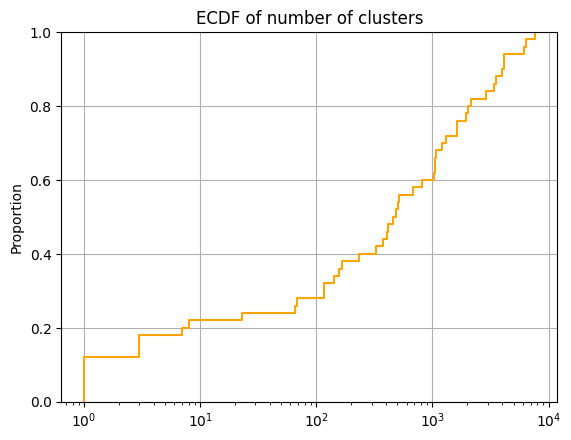

In [30]:
#ECDF OF CLUSTERS
# Visualize the ECDF of clusters
plt.figure()
sns.ecdfplot(counts,color = 'orange',log_scale = True) # x-axis is in logarithm scale
plt.title('ECDF of number of clusters')
plt.grid()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1362: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


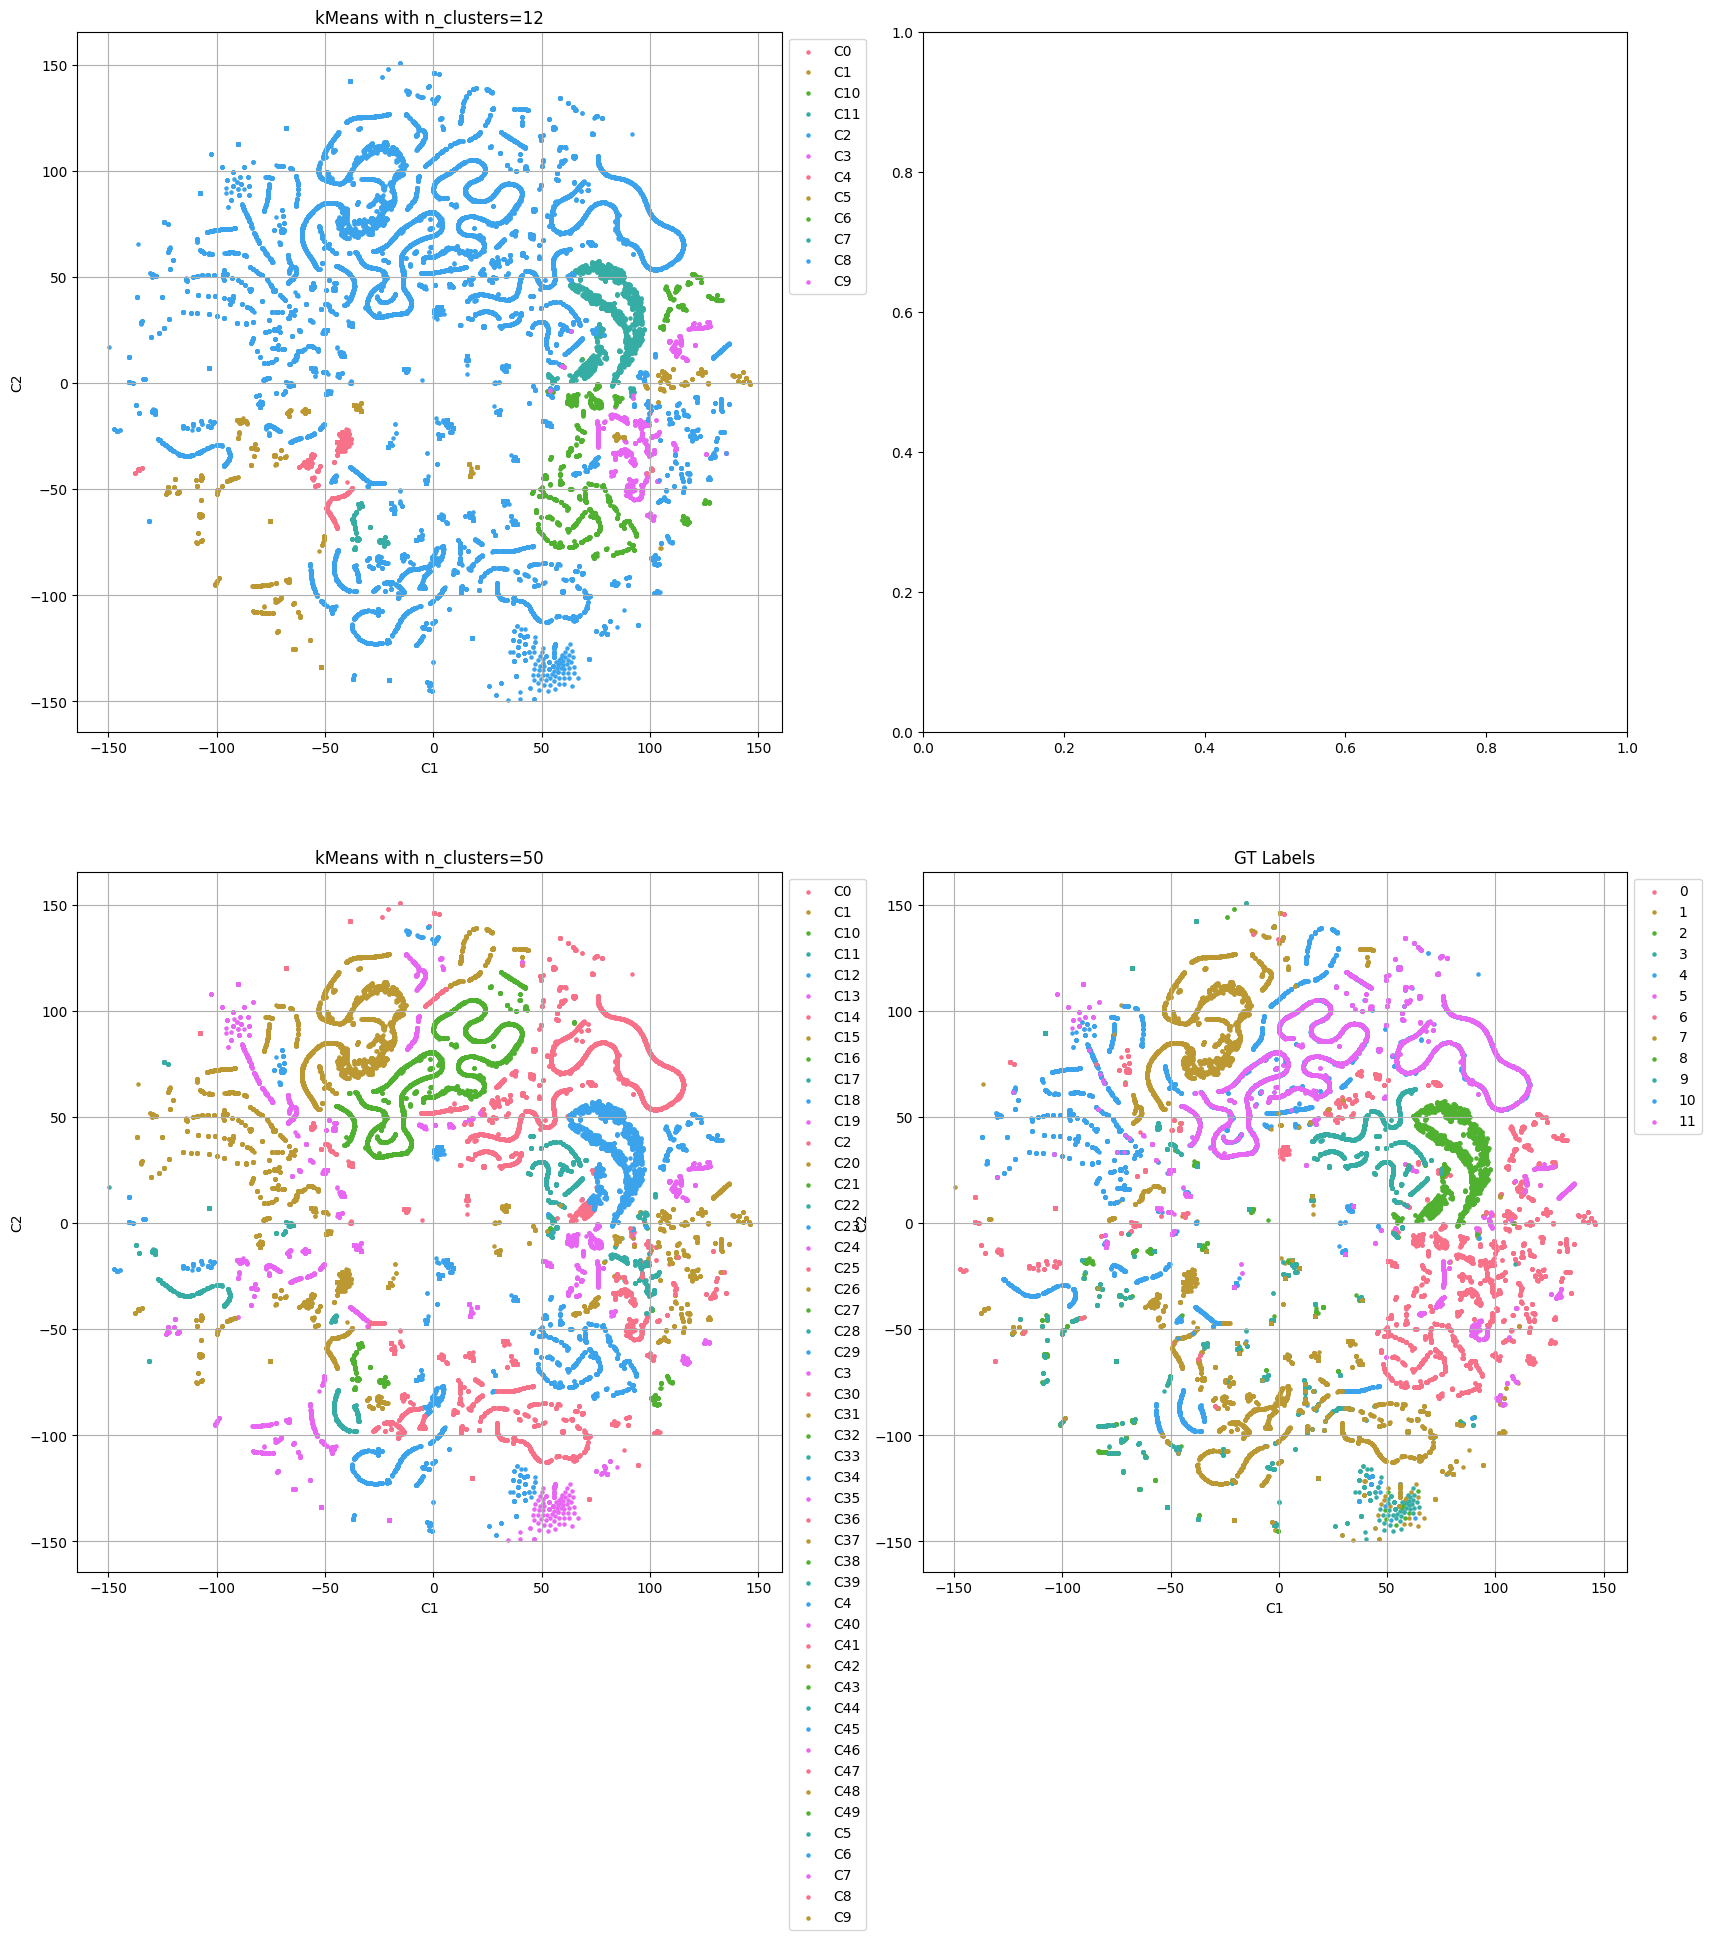

In [9]:
#SCATTER tSNE PLOTS CLUSTERS
#2D tSNE
from sklearn.manifold import TSNE
X_s_red_np = X_s_red.to_numpy()
best_centroids_np = np.array(best_centroids)

tsne = TSNE(n_components=2, n_jobs=-1)
projection = tsne.fit_transform(X_s_red_np)

projection = pd.DataFrame(projection)
kmeans = KMeans(n_clusters=50, init = best_centroids_np)
cl_labels = kmeans.fit_predict(X_s_red_np)
kmeans12 = KMeans(n_clusters=12)
cl_labels12 = kmeans12.fit_predict(X_s_red_np)

sns.set_palette('husl')
#sns.barplot(ax=axes[0], x=bulbasaur.index, y=bulbasaur.values)

projection['cid12'] = [f'C{x}' for x in cl_labels12]
projection['cidBest'] = [f'C{x}' for x in cl_labels]
projection['label'] = GT.reshape(-1)

fig, axs = plt.subplots(2, 2, figsize=(20, 20))

for i in np.unique(projection.cid12):
    subdf = projection[projection.cid12==i]
    axs[0,0].scatter(subdf[0], subdf[1], label=i, s=5)
axs[0,0].grid()
lgnd = axs[0,0].legend(bbox_to_anchor=(1, 1), loc="upper left")
axs[0,0].set_xlabel('C1')
axs[0,0].set_ylabel('C2')
axs[0,0].set_title('kMeans with n_clusters=12')

for i in np.unique(projection.cidBest):
    subdf = projection[projection.cidBest==i]
    axs[1, 0].scatter(subdf[0], subdf[1], label=i, s=5)
axs[1,0].grid()
lgnd = axs[1,0].legend(bbox_to_anchor=(1, 1), loc="upper left")
axs[1,0].set_xlabel('C1')
axs[1,0].set_ylabel('C2')
axs[1,0].set_title(f'kMeans with n_clusters=50')

for i in np.unique(GT):
    subdf = projection[projection.label==i]
    axs[1, 1].scatter(subdf[0], subdf[1], label=i, s=5)
axs[1,1].grid()
lgnd = axs[1,1].legend(bbox_to_anchor=(1, 1), loc="upper left")
axs[1,1].set_xlabel('C1')
axs[1,1].set_ylabel('C2')
axs[1,1].set_title('GT Labels')

plt.show()

Cluster analysis of the results obtained using the KMeans algorithm.

In [32]:
#DataFrame setup for analysis
labels = pd.DataFrame({'labels':GT})
clusters = pd.DataFrame({'clusters':cl_labels})
clu_gt_labels = pd.merge(labels,clusters,left_index=True, right_index=True)

df_copy = X_s_red.copy()
df_copy['cluster'] = cl_labels
df_copy['label'] = GT

cluster_centers = kmeans.cluster_centers_

In [33]:
#SEARCHING FOR THE MOST IMPORTANT FEATURES FOR CLUSTER DEFINITION
#outliers of the columns in the centroid matrix are most likely an important feature for the cluster, 2*sigma is the outlier definition
#the centroids are obtained after the kmeans fitting with best params and best centroids

from scipy.stats import zscore

def find_outliers(vettore):
    outliers = 0
    z_scores = zscore(vettore)
    std = np.std(vettore)
    soglia = 2*std
    outliers = abs(z_scores) > soglia
    return outliers

clusters_list = [[] for i in range(50)]

for c in range(cluster_centers.shape[1]):   #iterate on columns
  col = cluster_centers[:, c]
  outliers = find_outliers(col)
  clusters = np.where(outliers)[0] #get index of true for outliers

  for cl in clusters:
    clusters_list[cl].append(c)
  print(c, clusters)

0 []
1 []
2 [ 3 18 26 36]
3 [28]
4 [27 34]
5 []
6 []
7 []
8 [47]
9 []
10 []
11 []
12 [ 0  5 12 15 25 31 48]
13 [17]
14 [ 1 12 16 30 40 48]
15 []
16 []
17 [17]
18 []
19 [43]
20 [36]
21 [43 44]
22 [13 14 28 37]
23 [18 24 35 36]
24 []
25 [29]
26 []
27 []
28 [13 17]
29 [13 17 22 49]
30 [9]
31 [16]
32 [23]
33 [1]
34 [46]
35 [40 48]
36 [11 35]
37 []
38 []
39 [10]
40 [27 34]
41 [43]
42 [28 42]


In [34]:
#feature importance for clusters
features_print = X_s_red.columns

from prettytable import PrettyTable

tabella = PrettyTable()
tabella.field_names = ["Cluster", "Features"]
for i in range(len(clusters_list)):
  tmp=[]
  for j in clusters_list[i]:
    tmp.append(features_print[j])
  if tmp != []:
    tabella.add_row([i, set(tmp)])
print(tabella)

+---------+----------------------------------------------------------------------------------+
| Cluster |                                     Features                                     |
+---------+----------------------------------------------------------------------------------+
|    0    |                                {'Fwd Packets/s'}                                 |
|    1    |                    {' Source Port_672', ' Min Packet Length'}                    |
|    3    |                         {'Total Length of Fwd Packets'}                          |
|    5    |                                {'Fwd Packets/s'}                                 |
|    9    |                               {' Source Port_512'}                               |
|    10   |                             {' Destination Port_22'}                             |
|    11   |                              {' Source Port_61850'}                              |
|    12   |                     {' Min Packet Leng

In [35]:
#tabella 1
from prettytable import PrettyTable
gb = clu_gt_labels.groupby('labels')
tabella = PrettyTable()
tabella.field_names = ["Label", "Clusters"]
for g,k in gb:
  tabella.add_row([g, set(k.clusters)])
print(tabella)

+-------+--------------------------------------------------------------------------------------------------------------+
| Label |                                                   Clusters                                                   |
+-------+--------------------------------------------------------------------------------------------------------------+
|   0   |             {2, 6, 7, 8, 10, 13, 14, 17, 21, 22, 24, 27, 28, 29, 34, 37, 39, 42, 43, 44, 47, 49}             |
|   1   | {0, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 22, 24, 25, 26, 28, 30, 31, 36, 37, 39, 42, 45, 46} |
|   2   |                               {32, 40, 9, 42, 12, 48, 17, 16, 23, 24, 25, 30}                                |
|   3   |                      {0, 1, 4, 7, 40, 9, 8, 12, 46, 15, 48, 16, 14, 20, 23, 24, 25, 30}                      |
|   4   |                                  {35, 7, 8, 11, 12, 15, 19, 24, 25, 30, 31}                                  |
|   5   |                    {33

In [36]:
#tabella 2
from prettytable import PrettyTable
gb = clu_gt_labels.groupby('clusters')
tabella = PrettyTable()
tabella.field_names = ["Cluster", "Labels"]
for g,k in gb:
  tabella.add_row([g, set(k.labels)])
print(tabella)

+---------+-------------------------------+
| Cluster |             Labels            |
+---------+-------------------------------+
|    0    |          {1, 3, 6, 7}         |
|    1    |         {10, 3, 6, 7}         |
|    2    |        {0, 1, 5, 8, 9}        |
|    3    |              {1}              |
|    4    |          {1, 3, 6, 7}         |
|    5    |           {1, 6, 9}           |
|    6    |             {0, 8}            |
|    7    | {0, 1, 3, 4, 5, 6, 7, 10, 11} |
|    8    |   {0, 1, 3, 4, 6, 7, 10, 11}  |
|    9    |        {1, 2, 3, 6, 7}        |
|    10   |          {0, 1, 5, 7}         |
|    11   |             {8, 4}            |
|    12   |        {1, 2, 3, 4, 7}        |
|    13   |           {0, 1, 5}           |
|    14   |        {0, 1, 3, 5, 8}        |
|    15   |          {1, 3, 4, 7}         |
|    16   |        {1, 2, 3, 6, 7}        |
|    17   |       {0, 1, 2, 5, 7, 9}      |
|    18   |              {1}              |
|    19   |           {9, 10, 4}

In [37]:
df_copy = X_s_red.copy()
df_copy['cluster'] = cl_labels
df_copy['label'] = GT
df_copy.columns

Index([' Total Fwd Packets', ' Total Backward Packets',
       'Total Length of Fwd Packets', ' Fwd Packet Length Std',
       ' Bwd Packet Length Min', ' Flow IAT Max', ' Flow IAT Min',
       'Bwd IAT Total', ' Bwd IAT Std', ' Bwd IAT Min', 'Fwd PSH Flags',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Std',
       ' SYN Flag Count', ' URG Flag Count', ' Down/Up Ratio',
       ' Fwd Header Length.1', 'Init_Win_bytes_forward',
       ' Init_Win_bytes_backward', ' min_seg_size_forward', ' Active Max',
       ' Idle Std', 'Protocol_17', ' Source Port_-1', ' Source Port_80',
       ' Source Port_443', ' Source Port_512', ' Source Port_530',
       ' Source Port_648', ' Source Port_672', ' Source Port_678',
       ' Source Port_900', ' Source Port_61850', ' Destination Port_-1',
       ' Destination Port_0', ' Destination Port_22', ' Destination Port_53',
       ' Destination Port_80', ' Destination Port_

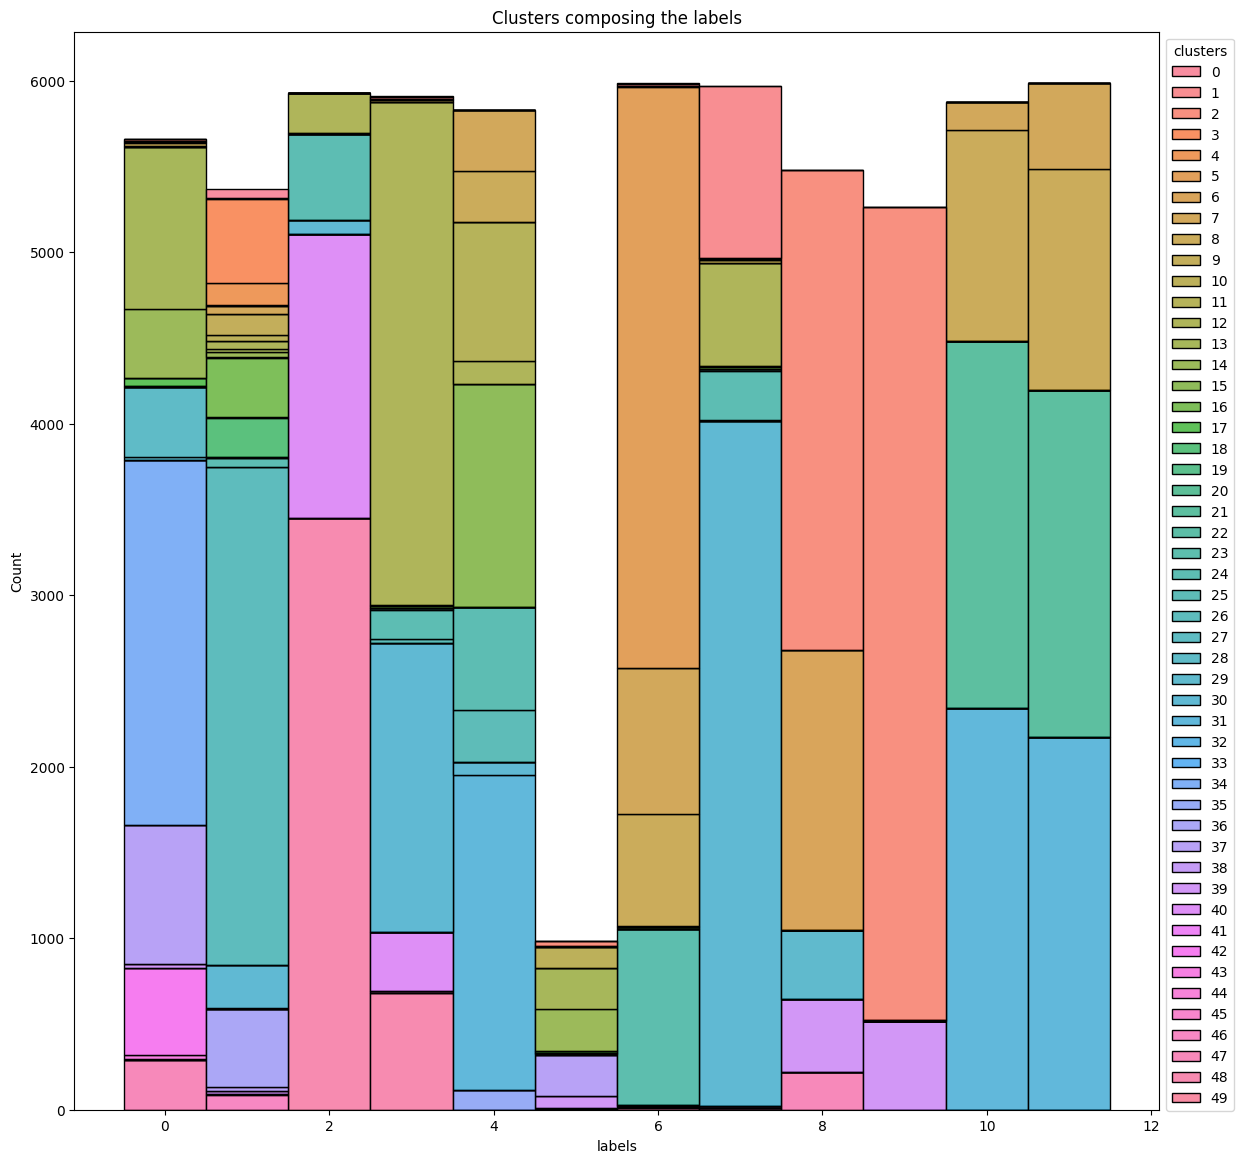

In [38]:
plt.figure(figsize = (14, 14))

ax = sns.histplot(
    data = clu_gt_labels,
    x = "labels", # the column you want to check
    hue = "clusters", # check the distribution of different flow types
    palette="husl",
    multiple="stack",
    discrete = True,
    bins = 12,
    alpha=0.8,
    binrange = (0,11)
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Clusters composing the labels')
plt.show()

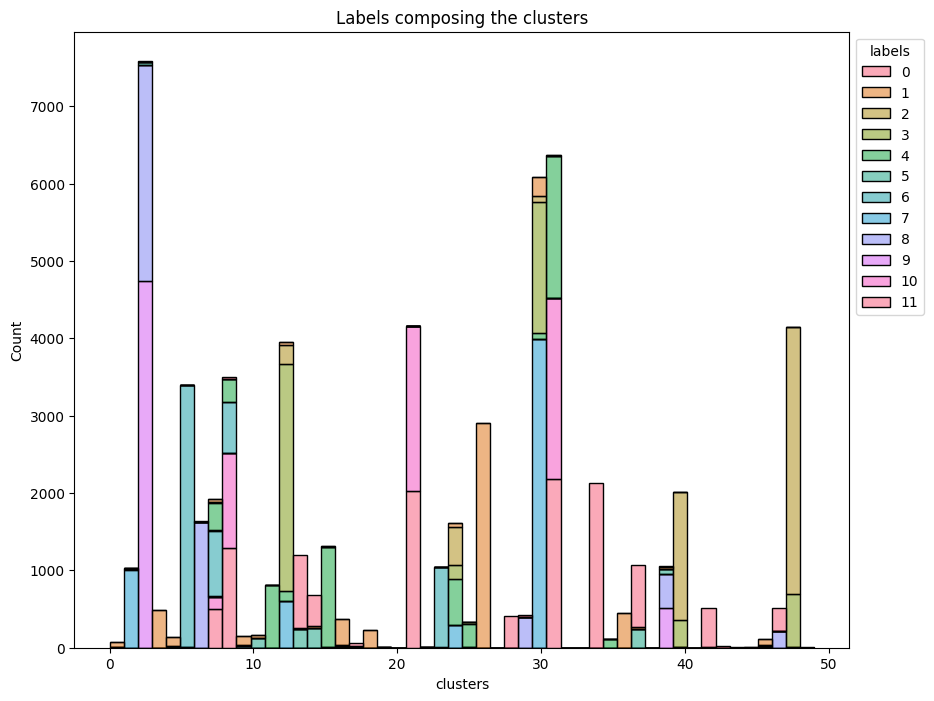

In [39]:
plt.figure(figsize = (10, 8))

ax = sns.histplot(
    data = clu_gt_labels,
    x = "clusters", # the column you want to check
    hue = "labels", # check the distribution of different flow types
    palette="husl",
    multiple="stack",
    bins = 50,
    binrange = (0,49),
    alpha = 0.6
)


sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
#plt.yscale("log")
plt.title('Labels composing the clusters')
plt.show()

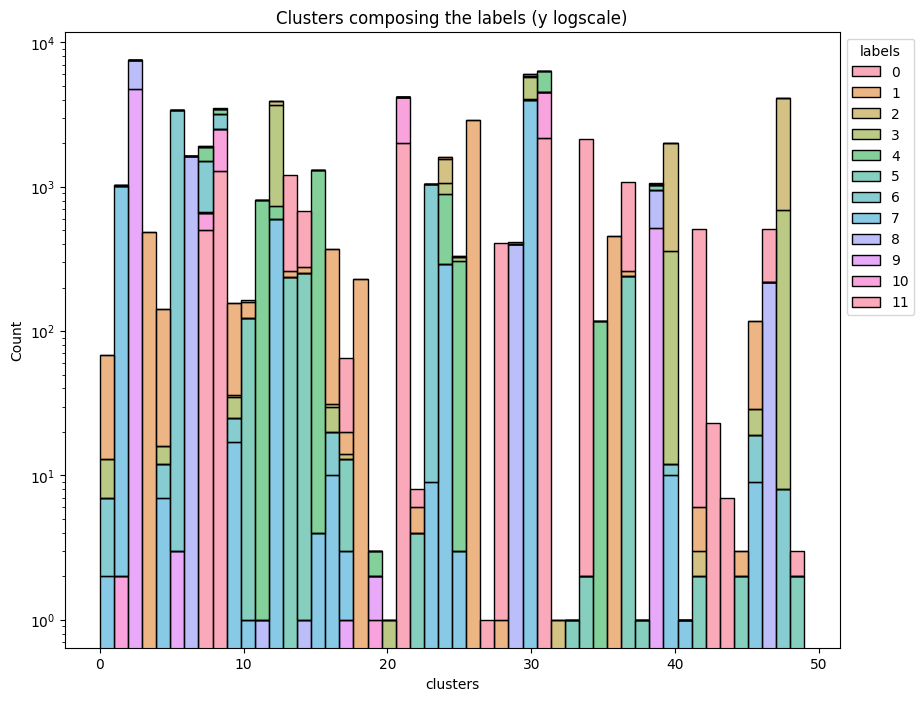

In [40]:
plt.figure(figsize = (10, 8))

ax = sns.histplot(
    data = clu_gt_labels,
    x = "clusters", # the column you want to check
    hue = "labels", # check the distribution of different flow types
    palette="husl",
    multiple="stack",
    bins = 50,
    binrange = (0,49),
    alpha = 0.6
)


sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.yscale("log")
plt.title('Clusters composing the labels (y logscale)')
plt.show()

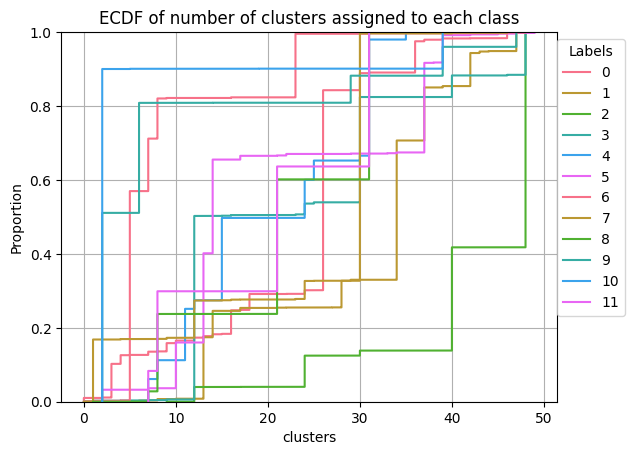

In [41]:
# Visualize the ECDF of clusters
sns.set_palette('husl')

plt.figure()
for lab in clu_gt_labels['labels'].unique():
  df_label = clu_gt_labels[clu_gt_labels.labels==lab]
  sns.ecdfplot(df_label.clusters)
plt.legend(np.sort(clu_gt_labels['labels'].unique()))
plt.title('ECDF of number of clusters assigned to each class')
plt.legend(bbox_to_anchor=(1.15, 1), loc='upper right',title ='Labels',labels = np.sort(clu_gt_labels['labels'].unique()))
plt.grid()
plt.show()

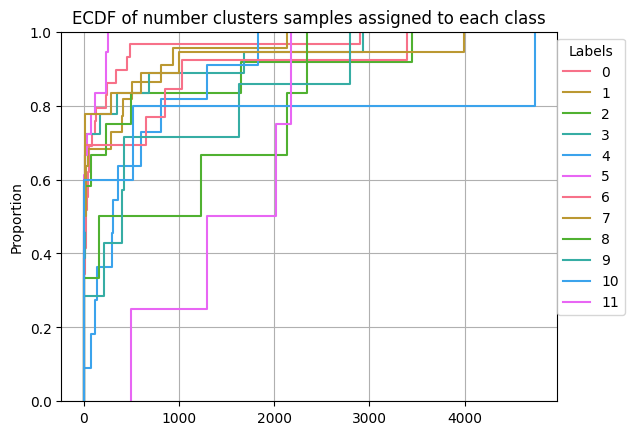

In [42]:
# Visualize the ECDF of clusters

plt.figure()
for lab in clu_gt_labels['labels'].unique():
  df_label = clu_gt_labels[clu_gt_labels.labels==lab]
  (unique,counts) = np.unique(df_label.clusters,return_counts=True)
  sns.ecdfplot(counts)
plt.legend(np.sort(clu_gt_labels['labels'].unique()))
plt.title('ECDF of number clusters samples assigned to each class')
plt.legend(bbox_to_anchor=(1.15, 1), loc='upper right',title ='Labels',labels = np.sort(clu_gt_labels['labels'].unique()))
plt.grid()
plt.show()

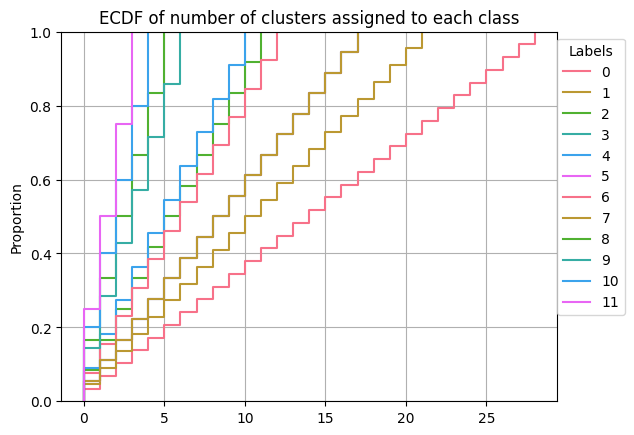

In [43]:
# Visualize the ECDF of clusters

plt.figure()
for lab in clu_gt_labels['labels'].unique():
  df_label = clu_gt_labels[clu_gt_labels.labels==lab]
  (unique,counts) = np.unique(df_label.clusters,return_counts=True)
  sns.ecdfplot(np.argsort(counts))
plt.legend(np.sort(clu_gt_labels['labels'].unique()))
plt.title('ECDF of number of clusters assigned to each class')
plt.legend(bbox_to_anchor=(1.15, 1), loc='upper right',title ='Labels',labels = np.sort(clu_gt_labels['labels'].unique()))
plt.grid()
plt.show()

In [44]:
#Decision Tree

from sklearn.tree import DecisionTreeClassifier

df_copy = X_s_red.copy()
df_copy['cluster'] = cl_labels
df_copy['label'] = GT

for label in clu_gt_labels['labels'].unique():
  #uncomment to visualize cluster assigning

  #clusterings = clu_gt_labels[clu_gt_labels['labels']==label]['clusters']
  #print(label, "   ", clusterings.unique())
  #print(clusterings.value_counts())

  #select a label
  df1 = df_copy[df_copy["label"] == label]
  df1 = df1.drop("label", axis = 1) #remove GT
  y = df1["cluster"]                #train on clusters to get feature importance
  df1 = df1.drop("cluster", axis = 1)
  clf = DecisionTreeClassifier(random_state=42)
  clf.fit(df1, y)

  feature_importance = clf.feature_importances_
  zipped = sorted(zip(df1.columns, feature_importance), key=lambda x: x[1], reverse=True)
  print(f'Most important features for label {label}: ', zipped[0], zipped[1], zipped[2])

Most important features for label 1:  ('Total Length of Fwd Packets', 0.37874311263290367) (' Fwd Header Length.1', 0.273695015673972) (' Source Port_530', 0.08808245326920014)
Most important features for label 0:  (' Destination Port_53', 0.34852724046854155) ('Total Length of Fwd Packets', 0.18892114946405325) (' Source Port_-1', 0.16399369572621028)
Most important features for label 2:  ('Fwd Packets/s', 0.5680625948638092) (' min_seg_size_forward', 0.25424418517308817) (' Source Port_900', 0.1739593509672761)
Most important features for label 3:  ('Fwd Packets/s', 0.4537042524349131) (' Source Port_-1', 0.41582237709400555) (' min_seg_size_forward', 0.043154403287079354)
Most important features for label 4:  ('Total Length of Fwd Packets', 0.2968643992424803) (' Fwd Header Length.1', 0.206968778457079) (' Flow IAT Max', 0.1811735783113039)
Most important features for label 5:  ('Init_Win_bytes_forward', 0.2826192240805534) (' Source Port_-1', 0.2642952203232215) (' Destination Port

In [45]:
pip install graphviz

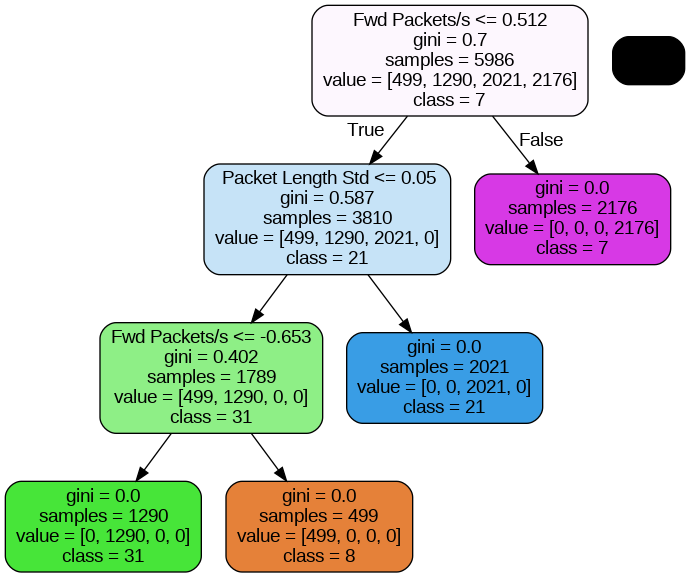

In [47]:
from sklearn.tree import export_graphviz
import graphviz
import pydotplus
from IPython.display import Image

#ISOLATING 10 and 11 and investigation
from sklearn.metrics import confusion_matrix

dff = X_s_red.copy()
dff["label"] = GT
dff['cluster'] = cl_labels


dff = dff[(dff["label"].isin([10, 11])) & (dff["cluster"].isin([8, 31, 21, 7]))]

y = dff["cluster"]
dff = dff.drop("cluster", axis = 1)
dff = dff.drop("label", axis = 1)

arr = ['8', '31', '21', '7']

dot_data = export_graphviz(clf, out_file = None, feature_names = dff.columns, class_names = arr, filled = True, rounded = True)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('decisiontree.png')
Image(filename = 'decisiontree.png')
#display(graphviz.Source(dot_data))

In [48]:
#decision tree uses only two features to classify the clusters, therefore demonstrating that only two features are relevant
#causing classifying errors both on supervised and unsupervised algorithms

print("Feature Importance:")
feature_importance = zip(dff.columns, clf.feature_importances_)
sorted_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)
for feature, importance in sorted_importance:
    print(f"{feature}: {importance}")


Feature Importance:
Fwd Packets/s: 0.6384002000826084
 Packet Length Std: 0.3615997999173915
 Total Fwd Packets: 0.0
 Total Backward Packets: 0.0
Total Length of Fwd Packets: 0.0
 Fwd Packet Length Std: 0.0
 Bwd Packet Length Min: 0.0
 Flow IAT Max: 0.0
 Flow IAT Min: 0.0
Bwd IAT Total: 0.0
 Bwd IAT Std: 0.0
 Bwd IAT Min: 0.0
Fwd PSH Flags: 0.0
 Bwd Header Length: 0.0
 Bwd Packets/s: 0.0
 Min Packet Length: 0.0
 Max Packet Length: 0.0
 SYN Flag Count: 0.0
 URG Flag Count: 0.0
 Down/Up Ratio: 0.0
 Fwd Header Length.1: 0.0
Init_Win_bytes_forward: 0.0
 Init_Win_bytes_backward: 0.0
 min_seg_size_forward: 0.0
 Active Max: 0.0
 Idle Std: 0.0
Protocol_17: 0.0
 Source Port_-1: 0.0
 Source Port_80: 0.0
 Source Port_443: 0.0
 Source Port_512: 0.0
 Source Port_530: 0.0
 Source Port_648: 0.0
 Source Port_672: 0.0
 Source Port_678: 0.0
 Source Port_900: 0.0
 Source Port_61850: 0.0
 Destination Port_-1: 0.0
 Destination Port_0: 0.0
 Destination Port_22: 0.0
 Destination Port_53: 0.0
 Destination Por

# DBSCAN

This section contains all the code used to test DBSCAN clustering algorithm on the provided dataset. Given the poor results we did not continue with an in-depth cluster analysis.

In [4]:
#DBSCAN no tuning
from sklearn.cluster import DBSCAN

X_s_red_np = X_s_red.to_numpy()

dbscan = DBSCAN(n_jobs=-1, min_samples=40)
cl_labels = dbscan.fit_predict(X_s_red_np) # Get clusters ID

# Unsupervised metric
silhouette  = silhouette_score(X_s_red_np, cl_labels)
# Supervised metrics
ri = rand_score(np.ravel(GT), cl_labels)
ari = adjusted_rand_score(np.ravel(GT), cl_labels)

print('DBSCAN')
(unique, counts)=np.unique( cl_labels, return_counts=True)
print("Size of each cluster: ", counts)
print("Number of clusters: ", len(counts))
print(f'Silhouette: {round(silhouette, 2)}')
print(f'RI: {round(ri, 2)}')
print(f'ARI: {round(ari, 2)}')

DBSCAN
Size of each cluster:  [ 4041   130  2576    84    60   218   444  2012    47   112 15652   139
   136   301   103   271   128   304   115    53    47   804   218    93
 15353    58    54    62   628   376    51    65   132    61    65   100
   219   115    89  4124  2009   173   327   129   829   123   647   126
    91    46    40    40   702   155    46  1600  5236  2280]
Number of clusters:  58
Silhouette: 0.57
RI: 0.84
ARI: 0.23


In [5]:
#Trying to tune DBSCAN
#eps:The maximum distance between two samples for one to be considered as in the neighborhood of the other, default 0.5. MOST IMPORTANT
#min_samples:The number of samples (or total weight) in a neighborhood for a point to be considered as a core point, default 5.

#eps ANALYSIS
from sklearn.cluster import DBSCAN
X_s_red_np = X_s_red.to_numpy()

eps_list=[]
shs_list = []
ri_list = []
ari_list = []
cluster_n_list = []


for e in np.arange(0.01, 1.4, 0.2):
  print(f'{e}---------------------------')
  dbscan = DBSCAN(eps = e)
  cl_labels = dbscan.fit_predict(X_s_red_np) # Get clusters ID

  # Unsupervised metric
  silhouette  = silhouette_score(X_s_red_np, cl_labels)
  # Supervised metrics
  ri = rand_score(np.ravel(GT), cl_labels)
  ari = adjusted_rand_score(np.ravel(GT), cl_labels)
  (unique, counts)=np.unique( cl_labels, return_counts=True)
  print("Size of each cluster: ", counts)
  print("Number of clusters: ", len(counts))
  print(f'Silhouette: {round(silhouette, 2)}')
  print(f'RI: {round(ri, 2)}')
  print(f'ARI: {round(ari, 2)}')
  eps_list.append(e)
  shs_list.append(silhouette)
  ri_list.append(ri)
  ari_list.append(ari)
  cluster_n_list.append(len(counts))

0.01---------------------------
Size of each cluster:  [8317   55 2556   84   55  198   27   35    7    6   33   21    7    6
    7    7  322   20  133    6    6    8   17    8   13   17    6    9
    8   47    5   20   81   30    5    5    5  108    9    8   19    5
    9    7    7   18    7    6    7    5    5    6    8   10  100   17
   16    7    5   29    6   15   14   37    5    7   24   16    6    7
   22    5    8   16    5    5   39    9   12   54   10   31   17    6
    6    5    9   13    6    5    8    6    5    7   18    6   10    5
   17   83 4046   76   98    9 1057    9   70   11    5   17    7    6
    5    5 3760   55 7526   34   51    5   22  389   25   21    7   11
   68    7   24   25   19  101   50  218   11   13   59    9   34   46
    5   15   18   17   25    5    8  225    5   16  161   22    8 2891
   17   48   56    6    8    8    7  170   11   49    9    5    7   15
   13   67    6    9    7    7   33    6   21   10   17 3660 1373   73
   32   99  352   23  

best eps:  0.01  with corresponding silhouette:  0.580857773429993


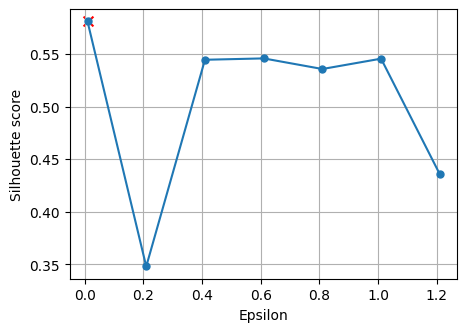

In [6]:
#eps curves
#ri, ari, shs, n_clusters

best_sh= np.max(shs_list)
best_e=eps_list[np.argmax(shs_list)]
print("best eps: ", best_e, " with corresponding silhouette: ", best_sh)

# Plot silhouette
plt.figure(figsize=(5, 3.5))
plt.plot(eps_list,shs_list, marker='o', markersize=5)
plt.scatter(best_e, best_sh, color='r', marker='x', s=50)
plt.grid()
plt.xlabel('Epsilon')
plt.ylabel('Silhouette score')
plt.show()

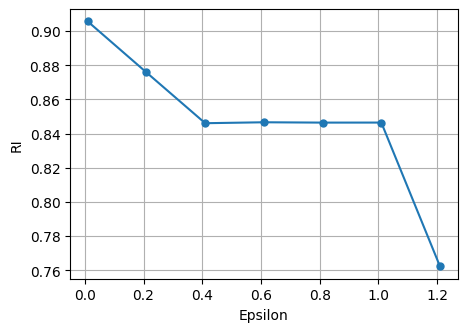

In [7]:
# Plot RI
plt.figure(figsize=(5, 3.5))
plt.plot(eps_list,ri_list, marker='o', markersize=5)
plt.grid()
plt.xlabel('Epsilon')
plt.ylabel('RI')
plt.show()

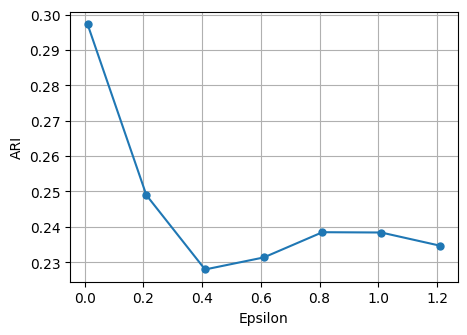

In [8]:
# Plot ARI
plt.figure(figsize=(5, 3.5))
plt.plot(eps_list,ari_list, marker='o', markersize=5)
plt.grid()
plt.xlabel('Epsilon')
plt.ylabel('ARI')
plt.show()

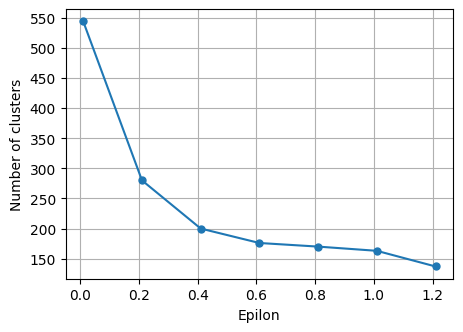

In [9]:
# Plot N_clusters
plt.figure(figsize=(5, 3.5))
plt.plot(eps_list,cluster_n_list, marker='o', markersize=5)
plt.grid()
plt.xlabel('Epilon')
plt.ylabel('Number of clusters')
plt.show()

In [10]:
#min_samples ANALYSIS
from sklearn.cluster import DBSCAN
X_s_red_np = X_s_red.to_numpy()

mins_list=[]
shs_list = []
ri_list = []
ari_list = []
cluster_n_list = []


for m in range(1, 40, 2):
  print(f'{m}---------------------------')
  dbscan = DBSCAN(n_jobs=-1, min_samples = m)
  cl_labels = dbscan.fit_predict(X_s_red_np) # Get clusters ID

  # Unsupervised metric
  silhouette  = silhouette_score(X_s_red_np, cl_labels)
  # Supervised metrics
  ri = rand_score(np.ravel(GT), cl_labels)
  ari = adjusted_rand_score(np.ravel(GT), cl_labels)
  (unique, counts)=np.unique( cl_labels, return_counts=True)
  print("Size of each cluster: ", counts)
  print("Number of clusters: ", len(counts))
  print(f'Silhouette: {round(silhouette, 2)}')
  print(f'RI: {round(ri, 2)}')
  print(f'ARI: {round(ari, 2)}')
  mins_list.append(m)
  shs_list.append(silhouette)
  ri_list.append(ri)
  ari_list.append(ari)
  cluster_n_list.append(len(counts))

1---------------------------
Size of each cluster:  [  27  130 2576 ...    1    1    1]
Number of clusters:  1519
Silhouette: 0.43
RI: 0.85
ARI: 0.23
3---------------------------
Size of each cluster:  [ 1383    27   130  2576    84     3    60   432   444     3     7     3
    10     9     6     5     3  2012    10    48    10   183     5 15652
   139   150    75    15     3    62   326   103     4    12    20     4
     7    24    18   274   129   304    40    29    15    22   115     7
    27    53     3    19    14    18    20     6    41     6    13    11
    17   804   268    36   107    20    33    19    41     7     7 15353
    58    13     4     7    54    62    24   628    18    13   477    13
    26    57     6    25    13    25     3     5     3    65   139     9
     8    16     3     3     3     6     3     3     4     5    99    37
     4    65     4     6     3   219    11     5     7     4     3     7
     3   115     6     5    19     5    89     7     7  4124  2009  

best mins:  35  with corresponding silhouette:  0.5687905109724157


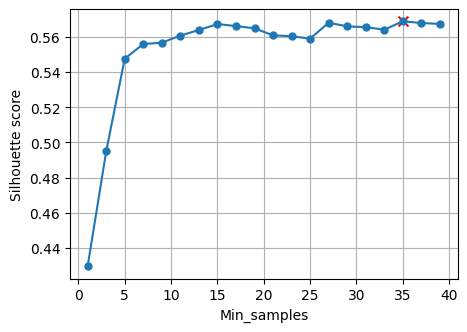

In [11]:
#min_samples curves
#ri, ari, shs, n_clusters

best_sh= np.max(shs_list)
best_mins=mins_list[np.argmax(shs_list)]
print("best mins: ", best_mins, " with corresponding silhouette: ", best_sh)

# Plot silhouette
plt.figure(figsize=(5, 3.5))
plt.plot(mins_list,shs_list, marker='o', markersize=5)
plt.scatter(best_mins, best_sh, color='r', marker='x', s=50)
plt.grid()
plt.xlabel('Min_samples')
plt.ylabel('Silhouette score')
plt.show()

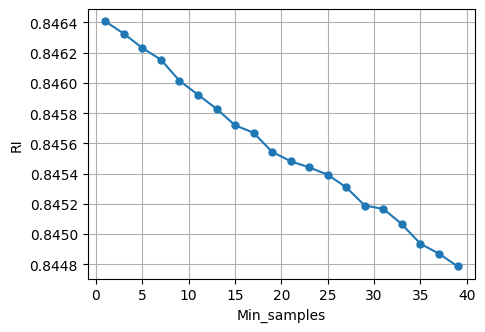

In [12]:
# Plot RI
plt.figure(figsize=(5, 3.5))
plt.plot(mins_list,ri_list, marker='o', markersize=5)
plt.grid()
plt.xlabel('Min_samples')
plt.ylabel('RI')
plt.show()

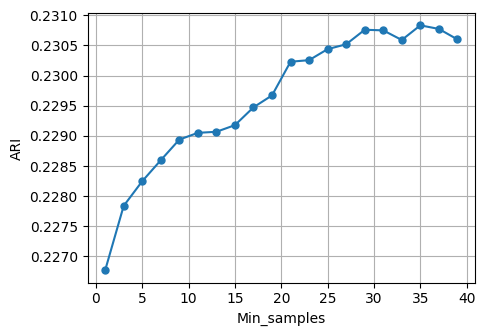

In [13]:
# Plot ARI
plt.figure(figsize=(5, 3.5))
plt.plot(mins_list,ari_list, marker='o', markersize=5)
plt.grid()
plt.xlabel('Min_samples')
plt.ylabel('ARI')
plt.show()

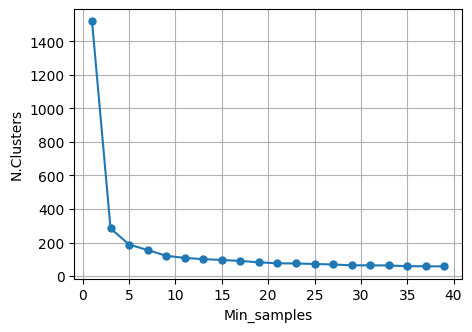

In [14]:
# Plot N_clusters
plt.figure(figsize=(5, 3.5))
plt.plot(mins_list,cluster_n_list, marker='o', markersize=5)
plt.grid()
plt.xlabel('Min_samples')
plt.ylabel('N.Clusters')
plt.show()

In [15]:
# Now analyze the performance varying epsilon and min_samples.

shs = []
X_s_red_np = X_s_red.to_numpy()
for eps in np.arange(0.6, 1, 0.1):
    eps = round(eps,3)
    for mins in range(30, 40):
        print(f'eps:{eps}, mins:{mins}---------------------------------------------')
        dbscan = DBSCAN(eps=eps, min_samples=mins, n_jobs=-1)
        cl_labels = dbscan.fit_predict(X_s_red_np)
        try:
            silhouette  = silhouette_score(X_s_red_np, cl_labels)
        except:
            silhouette = np.nan

        shs.append((eps, mins, silhouette))
        ri = rand_score(np.ravel(GT), cl_labels)
        ari = adjusted_rand_score(np.ravel(GT), cl_labels)
        print(f'Silhouette: {round(silhouette, 2)}')
        print(f'RI: {round(ri, 2)}')
        print(f'ARI: {round(ari, 2)}')
        (unique, counts)=np.unique( cl_labels, return_counts=True)
        print("Number of clusters: ", len(counts))
gs = pd.DataFrame(shs, columns=['eps', 'minPts', 'sh'])
gs = pd.pivot_table(gs, columns='eps', index='minPts', values='sh', aggfunc=lambda x:x)



eps:0.6, mins:30---------------------------------------------
Silhouette: 0.57
RI: 0.85
ARI: 0.23
Number of clusters:  66
eps:0.6, mins:31---------------------------------------------
Silhouette: 0.57
RI: 0.85
ARI: 0.23
Number of clusters:  66
eps:0.6, mins:32---------------------------------------------
Silhouette: 0.57
RI: 0.85
ARI: 0.23
Number of clusters:  66
eps:0.6, mins:33---------------------------------------------
Silhouette: 0.57
RI: 0.85
ARI: 0.23
Number of clusters:  64
eps:0.6, mins:34---------------------------------------------
Silhouette: 0.57
RI: 0.85
ARI: 0.23
Number of clusters:  62
eps:0.6, mins:35---------------------------------------------
Silhouette: 0.57
RI: 0.85
ARI: 0.23
Number of clusters:  62
eps:0.6, mins:36---------------------------------------------
Silhouette: 0.56
RI: 0.85
ARI: 0.23
Number of clusters:  59
eps:0.6, mins:37---------------------------------------------
Silhouette: 0.57
RI: 0.85
ARI: 0.23
Number of clusters:  58
eps:0.6, mins:38--------

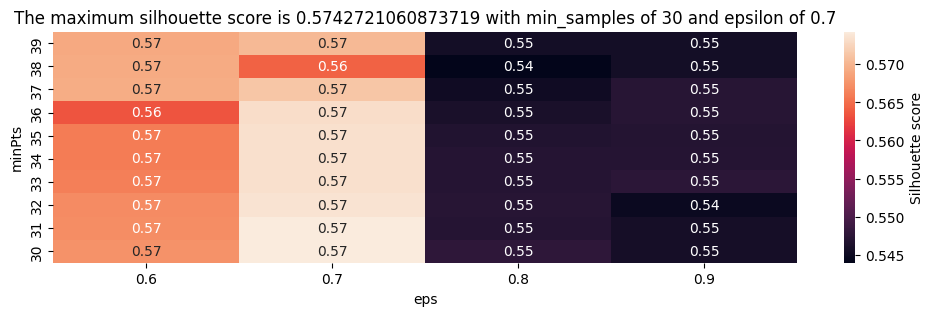

In [16]:
# Plot the silhouette score for the different values with a heatmap

plt.figure(figsize=(12,3))
max_ss = gs.max().max()
mins_max_ss = gs.stack().idxmax()[0]
eps_max_ss = gs.stack().idxmax()[1]
plt.title(f'The maximum silhouette score is {max_ss} with min_samples of {mins_max_ss} and epsilon of {eps_max_ss}')
sns.heatmap(gs, cbar_kws={'label':'Silhouette score'}, annot=True)
plt.gca().invert_yaxis()
plt.show()

In [17]:
#DBSCAN best params
#notice the two big 15k elements clusters which causes low scores
from sklearn.cluster import DBSCAN

X_s_red_np = X_s_red.to_numpy()

dbscan = DBSCAN(eps=0.7, min_samples=36, n_jobs=-1)
cl_labels = dbscan.fit_predict(X_s_red_np) # Get clusters ID

# Unsupervised metric
silhouette  = silhouette_score(X_s_red_np, cl_labels)
# Supervised metrics
ri = rand_score(np.ravel(GT), cl_labels)
ari = adjusted_rand_score(np.ravel(GT), cl_labels)

print('DBSCAN')
(unique, counts)=np.unique( cl_labels, return_counts=True)
print("Size of each cluster: ", counts)
print("Number of clusters: ", len(counts))
print(f'Silhouette: {round(silhouette, 2)}')
print(f'RI: {round(ri, 2)}')
print(f'ARI: {round(ari, 2)}')

DBSCAN
Size of each cluster:  [ 3316   130  2795    95    60   232   448    57  2056    48   139 15654
   139   151    65    63   310   103   274   131   304   116    53   813
   226    41    93    35    41   160 15353    58    54    63   628   478
    57    37    65   128   115    89  4134  2009   328   328   161   831
   123   662   132    91    46    36    30    36  2307   702    47  1679
  5236    48]
Number of clusters:  62
Silhouette: 0.57
RI: 0.85
ARI: 0.23


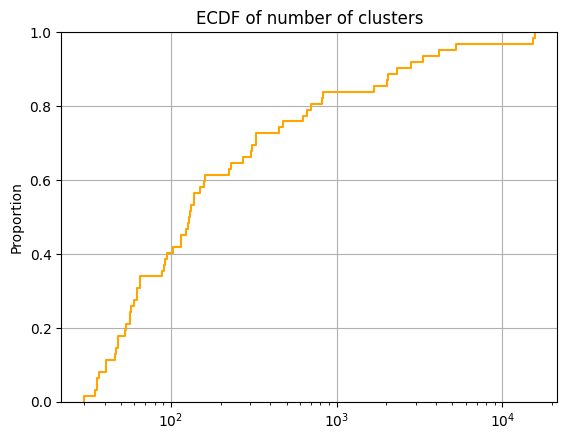

In [18]:
#ECDF
# Visualize the ECDF of clusters
plt.figure()
sns.ecdfplot(counts,color = 'orange',log_scale = True) # x-axis is in logarithm scale
plt.title('ECDF of number of clusters')
plt.grid()
plt.show()

In [19]:
#SCATTER tSNE PLOTS CLUSTERS
#2D tSNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, n_jobs=-1)
projection = tsne.fit_transform(X_s_red_np)
projection = pd.DataFrame(projection)

dbscan = DBSCAN(eps=0.7, min_samples=36, n_jobs=-1)
cl_labels = dbscan.fit_predict(X_s_red_np)

dbscan_default = DBSCAN(n_jobs=-1)
cl_labels_default = dbscan_default.fit_predict(X_s_red_np)

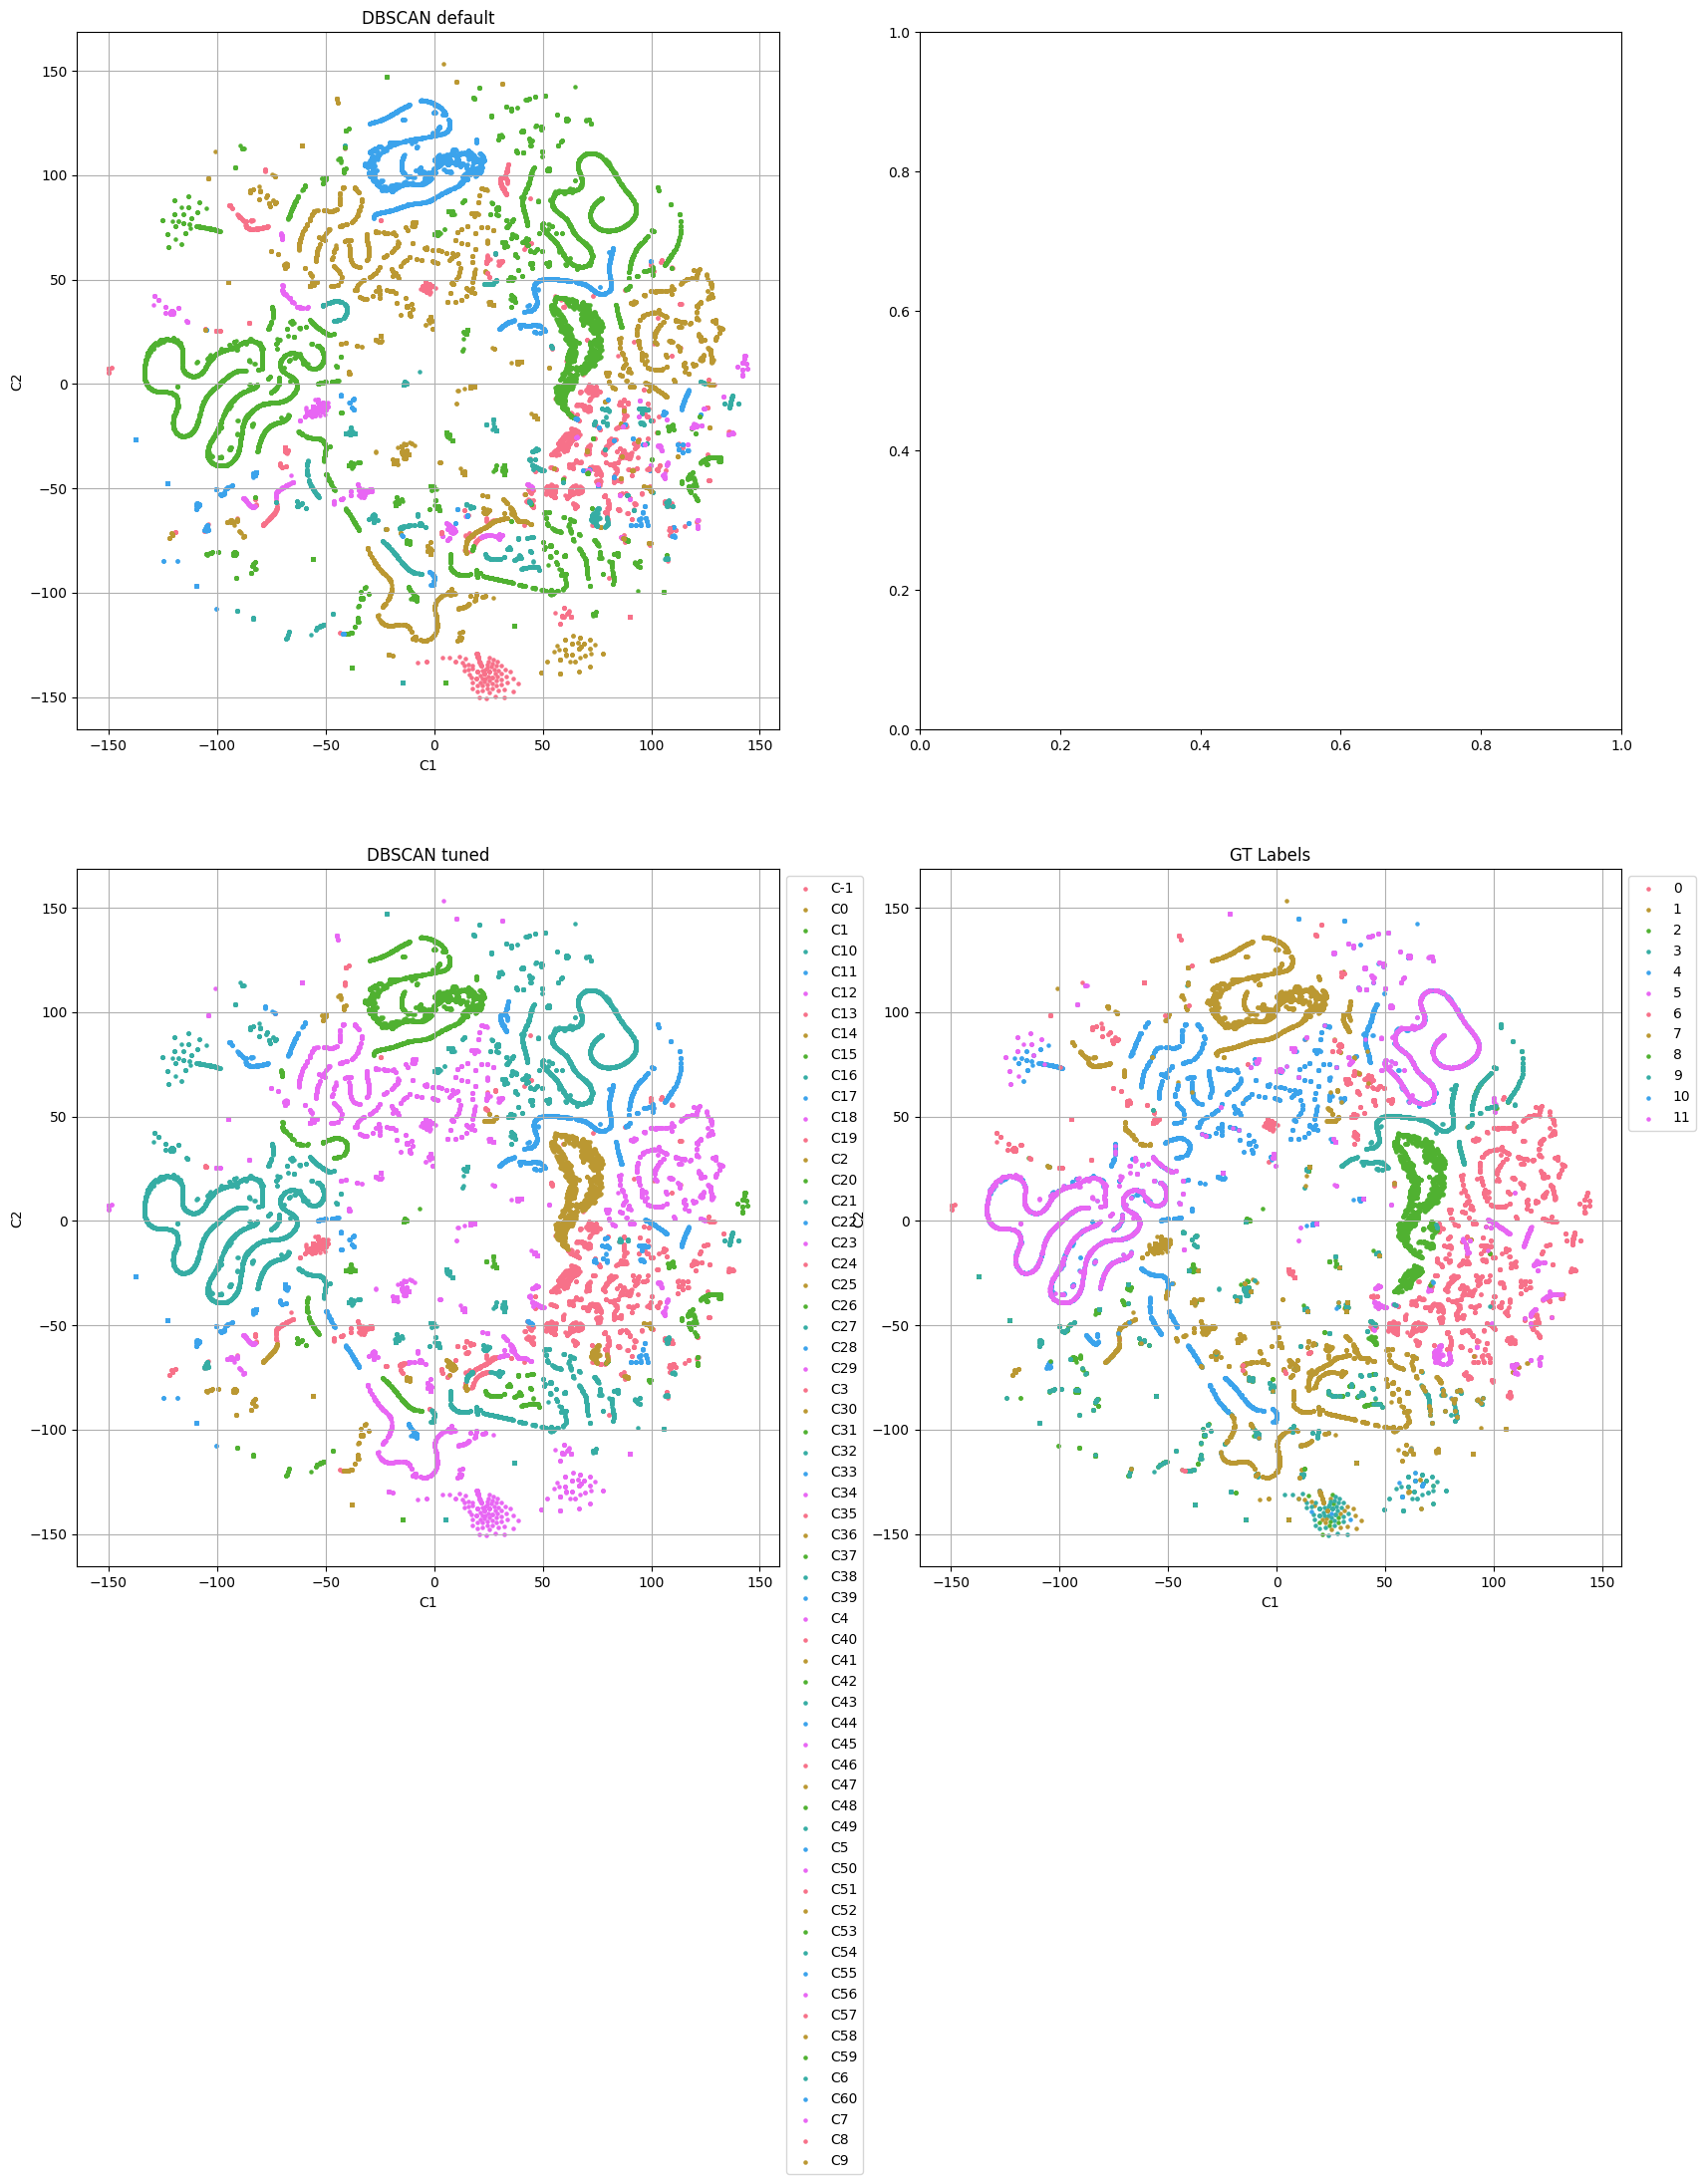

In [20]:
sns.set_palette('husl')

#SCATTERPLOT tSNE
projection['cid'] = [f'C{x}' for x in cl_labels_default]
projection['cidBest'] = [f'C{x}' for x in cl_labels]
projection['label'] = GT.reshape(-1)

fig, axs = plt.subplots(2, 2, figsize=(20, 20))

for i in np.unique(projection.cid):
    subdf = projection[projection.cid==i]
    axs[0, 0].scatter(subdf[0], subdf[1], label=i, s=5)
axs[0, 0].grid()
axs[0, 0].set_xlabel('C1')
axs[0, 0].set_ylabel('C2')
axs[0, 0].set_title('DBSCAN default')

for i in np.unique(projection.cidBest):
    subdf = projection[projection.cidBest==i]
    axs[1, 0].scatter(subdf[0], subdf[1], label=i, s=5)
axs[1, 0].grid()
lgnd = axs[1, 0].legend(bbox_to_anchor=(1, 1), loc="upper left")
axs[1, 0].set_xlabel('C1')
axs[1, 0].set_ylabel('C2')
axs[1, 0].set_title('DBSCAN tuned')

for i in np.unique(GT):
    subdf = projection[projection.label==i]
    axs[1, 1].scatter(subdf[0], subdf[1], label=i, s=5)
axs[1, 1].grid()
lgnd = axs[1, 1].legend(bbox_to_anchor=(1, 1), loc="upper left")
axs[1, 1].set_xlabel('C1')
axs[1, 1].set_ylabel('C2')
axs[1, 1].set_title('GT Labels')

plt.show()